# Cash Demand Forecasting of ATM

The goal of this work is to forecast daily cash demands of ATMs (Automated Teller Machines) for the following month, by using 1 year long logs of loaded and withdrawed cashes on daily basis. 

The dataset includes 3 features: CashIn, CashOut, and Date;
- CashIn : contains the total deposit amount of the ATM for the given date. 
- CashOut : the withdrawal values of given date on ATM. 
- Date : Daily given dates

It contains 1.186 observations at total which corresponds to 1.186 days starting from 01.01.2016 to 03.31.2019. 
Eventually it has been expected to forecast the CashIn and CashOut values between 2019-04-01 and 2019-04-30 separately. 


Initially, I plan to do Exploratory Data Analysis to understand raw data and add additional features generated from dates to streghten the capability of implemented algorithms. 

I would like to mention that, since I have no evidence to know the location of the ATM, I tried not to add location specific informations as features. But if I knew the exact location, adding a flag to  local holidays would be a good indicator, or even location specific weather might be useful to predict ATM usage. But for now, I only stick to the date column to derive new features. However, I assume that the first and last business days of a month have similar effects on cash flow in many locations so I added them as dummy features.


Subsequent to these data preperation and understanding steps, structure of this project is following a path to implement several approaches under separate subtopics to forecast cash demands. These topics can be summarized as below;

- Time series methods that predict future cash need based on the past values 
- Using LSTM to predict future cash demands based on the past values 
- Supervised learning methods that predict future cash demand by using derived features and treat the dataset as static data

Last but not least, since there are both loaded cash and withdrawed cash are tracked in same time lag, this dataset can be treated as multivariate time series with dependencies to each other. However, in this study, I have no clue that, this cash flow amounts have some impact on each other. Of course correlation value between them may explain some part of it, but as it is suggested on the study guidance section, I will treat these CashIn and CashOut values separately as independent univariate time series, so I will set the models one by one for each of them separately.


Eventually, final prediction method will be decided and implemented and then exported as csv file for both loaded cash and withdrawed cash amounts. 

It should be noted that, this study has been handled in a restricted time period, so analyses in subsections kept limited. There is unlimited scope, both vertically and horizontally, to improve results.



## EDA and Data Preperation/Augmentation

In [1576]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from math import sqrt
import tensorflow as tf
from tensorflow import keras
import warnings

In [1577]:
df_init = pd.read_csv("ds_exercise_data.csv")

In [1578]:
df_init.shape

(1186, 3)

In [1579]:
df_init.tail()

,Date,CashIn,CashOut
1181,3/27/2019,45160.0,48600.0
1182,3/28/2019,39480.0,22840.0
1183,3/29/2019,70260.0,25950.0
1184,3/30/2019,19250.0,24350.0
1185,3/31/2019,46870.0,14400.0


In [1580]:
df_init.Date = pd.to_datetime(df.Date)
df_init.CashIn = df.CashIn.fillna(0).astype('float')
df_init.CashOut = df.CashOut.fillna(0).astype('float')

In [1581]:
unseen = pd.DataFrame(index = range(df_init.shape[0],df_init.shape[0]+30), columns = ['Date', 'CashIn', 'CashOut'])
unseen['Date'] = pd.date_range('2019-04-01', periods=30, freq='D')

In [1582]:
df = pd.concat([df_init, unseen], axis=0)

In [1583]:
df.tail()

,Date,CashIn,CashOut
1211,2019-04-26,NaN,NaN
1212,2019-04-27,NaN,NaN
1213,2019-04-28,NaN,NaN
1214,2019-04-29,NaN,NaN
1215,2019-04-30,NaN,NaN


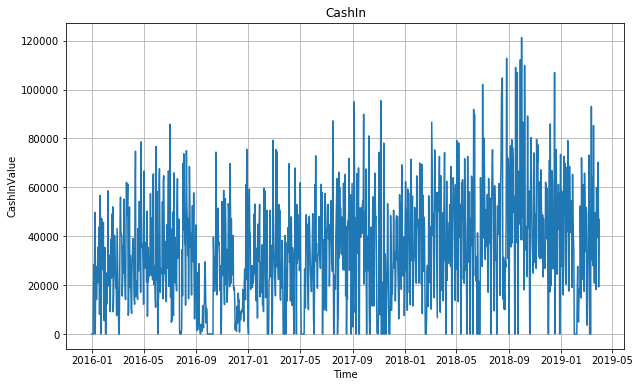

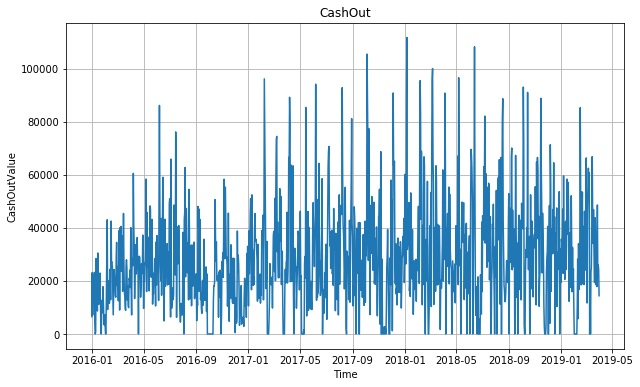

In [1584]:
for series in ['CashIn', 'CashOut']:
    plt.figure(figsize=(10, 6))
    plt.plot(df.Date, df[series])
    plt.xlabel("Time")
    plt.ylabel(str(series) + "Value")
    plt.title(str(series))
    plt.grid(True)
    plt.show()

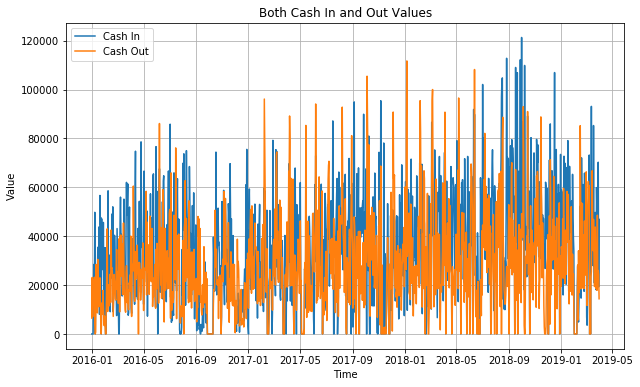

In [1585]:
plt.figure(figsize=(10, 6))
plt.plot(df.Date, df.CashIn, label = 'Cash In')
plt.plot(df.Date,  df.CashOut, label = 'Cash Out')
plt.xlabel("Time")
plt.ylabel("Value")
plt.title('Both Cash In and Out Values')
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [1586]:
def plot_new_col(df, Series, column):
    if df[column].nunique()>7:
        plt.figure(figsize=(10, 6))
        sns.regplot(x=column, y=Series, data=df)
        plt.xlabel(str(column))
        plt.ylabel("Cash Amount")
        plt.title(str(Series))
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[column],y= df[Series])
        plt.xlabel(str(column))
        plt.ylabel("Cash Amount")
        plt.title(str(Series))
        plt.show()


In [1587]:
# generate a new dummy column to show if date is a business day or not. Filled with "1" for True

df = df.assign(is_bday = np.where(df.Date.isin(pd.bdate_range(min(df.Date), max(df.Date)).values), 1, 0))

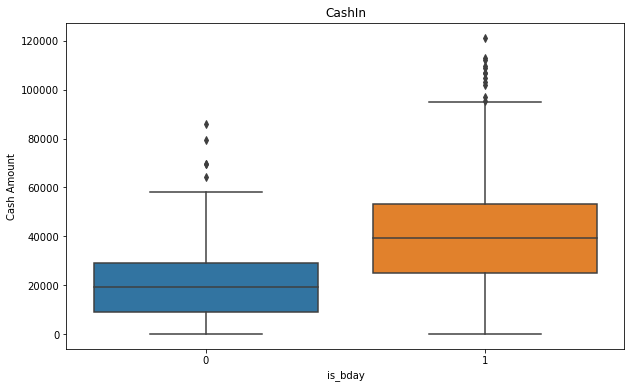

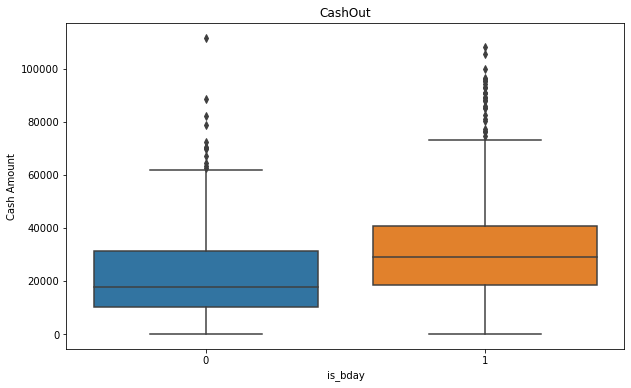

In [1588]:
for col in ['CashIn', 'CashOut']:
    plot_new_col(df, col, 'is_bday')

In [1589]:
df['Day_Name'] = df.Date.apply(lambda x: calendar.day_name[x.weekday()])

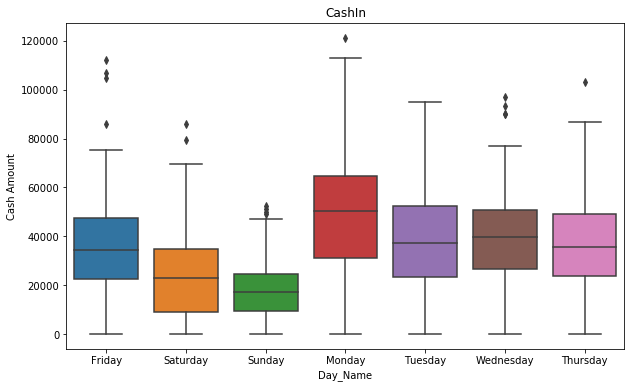

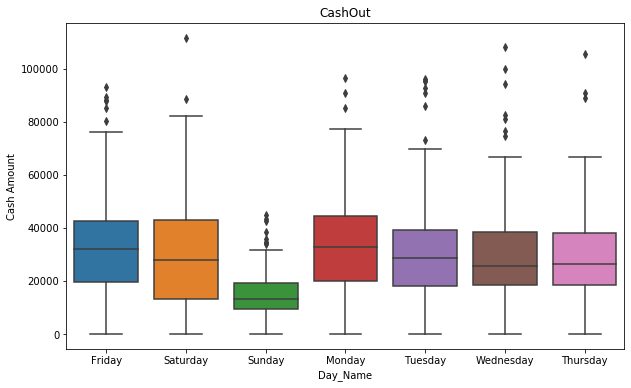

In [1590]:
for col in ['CashIn', 'CashOut']:
    plot_new_col(df, col, 'Day_Name')


In [1591]:
df = pd.concat([df, pd.get_dummies(df.Day_Name, prefix = 'is_')], axis=1).drop(['Day_Name'], axis=1)

In [1592]:
df['day_nr'] = df.Date.apply(lambda x: x.day)

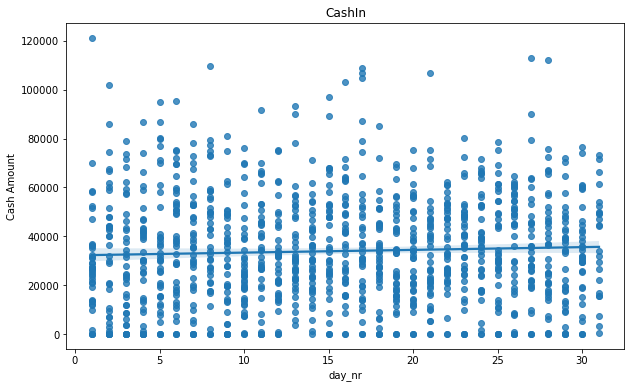

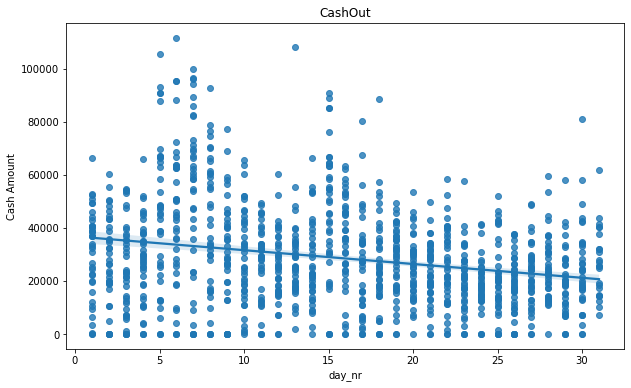

In [1593]:
for col in ['CashIn', 'CashOut']:
    plot_new_col(df, col, 'day_nr')

In [1594]:
df['month_nr'] = df.Date.apply(lambda x: x.month)

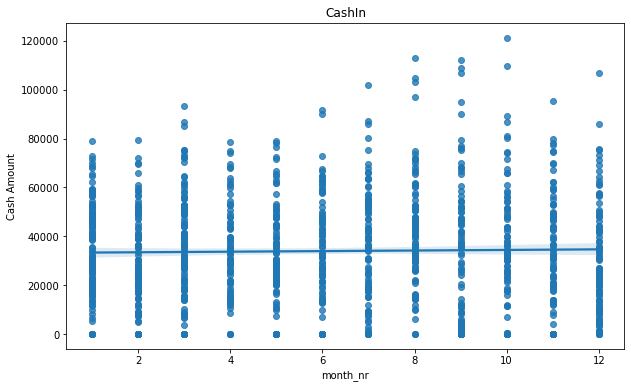

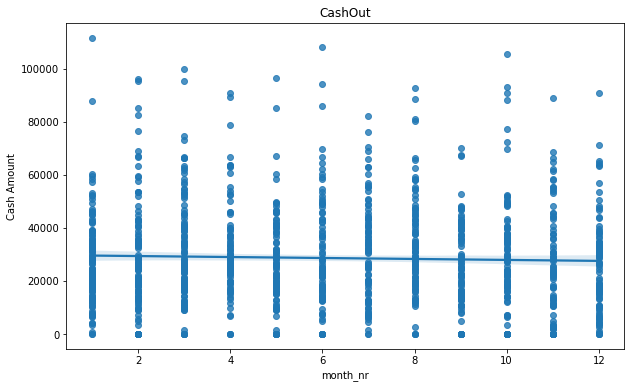

In [1595]:
for col in ['CashIn', 'CashOut']:
    plot_new_col(df, col, 'month_nr')

In [1596]:
df['year_nr'] = df.Date.apply(lambda x: x.year)

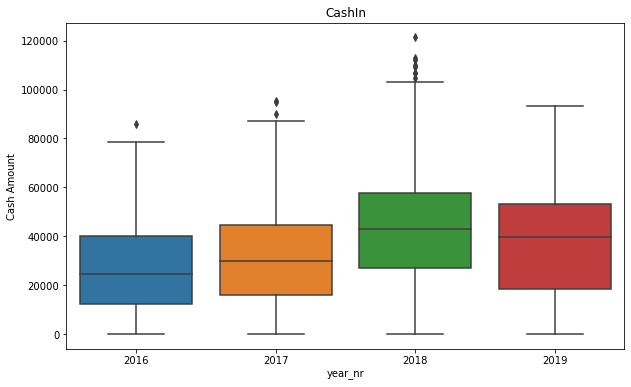

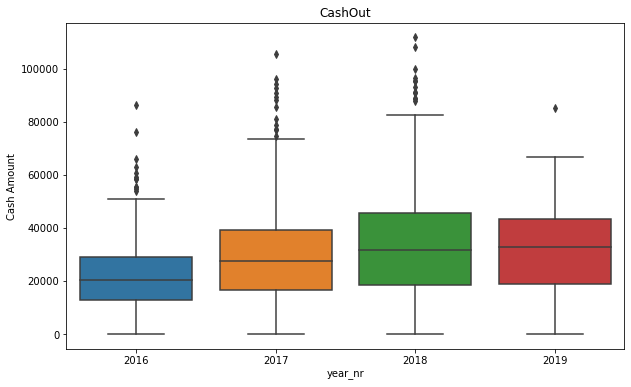

In [1597]:
for col in ['CashIn', 'CashOut']:
    plot_new_col(df, col, 'year_nr')

In [1598]:
# generate week of month column by calculating it per month to add as a feature
df = df.assign(week_of_month = np.where(df.day_nr<=7,1, np.where(df.day_nr<=14,2,np.where(df.day_nr<=21,3, np.where(df.day_nr<=28,4,5)))))

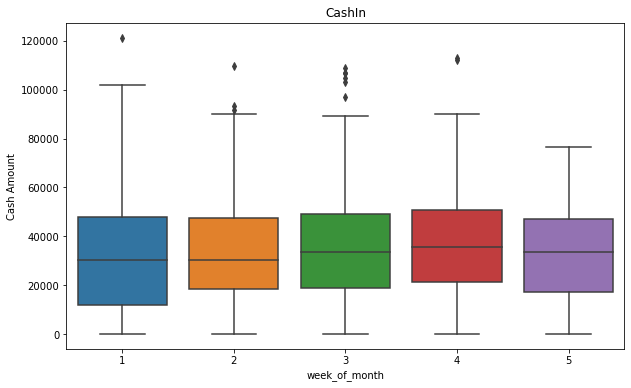

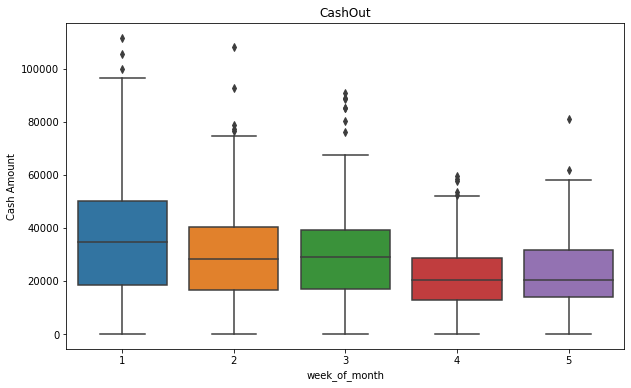

In [1599]:
for col in ['CashIn', 'CashOut']:
    plot_new_col(df, col, 'week_of_month')

In [1600]:
# Define first business day of month as dummy feature, if it is True filled with "1" else "0"
firstbd_col = []
lastbd_col = []
for j in df.year_nr.unique():
    for i in df.month_nr.unique():
        if i<= max(df[(df.year_nr==j)].month_nr):
            firstbd_col.append(np.where((df[(df.month_nr==i)&(df.year_nr==j)].day_nr == min(df[(df.is_bday==1)&(df.month_nr==i)&(df.year_nr==j)].day_nr)), 1,0))
            lastbd_col.append(np.where((df[(df.month_nr==i)&(df.year_nr==j)].day_nr == max(df[(df.is_bday==1)&(df.month_nr==i)&(df.year_nr==j)].day_nr)), 1,0))
            continue
        else:
            break


In [1601]:
first_bday_of_month = [col for cols in firstbd_col for col in cols]

In [1602]:
df = pd.concat([df,pd.DataFrame(first_bday_of_month)], axis = 1)

In [1603]:
df.head()

,Date,CashIn,CashOut,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,day_nr,month_nr,year_nr,week_of_month,0
0,2016-01-01,0.0,6500.0,1,1,0,0,0,0,0,0,1,1,2016,1,1
1,2016-01-02,0.0,23110.0,0,0,0,1,0,0,0,0,2,1,2016,1,0
2,2016-01-03,0.0,7070.0,0,0,0,0,1,0,0,0,3,1,2016,1,0
3,2016-01-04,0.0,18520.0,1,0,1,0,0,0,0,0,4,1,2016,1,0
4,2016-01-05,20840.0,22200.0,1,0,0,0,0,0,1,0,5,1,2016,1,0


In [1604]:
df.rename({df.columns[-1]: 'first_bday_of_month'}, axis=1, inplace=True)

In [1605]:
df.head()

,Date,CashIn,CashOut,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,day_nr,month_nr,year_nr,week_of_month,first_bday_of_month
0,2016-01-01,0.0,6500.0,1,1,0,0,0,0,0,0,1,1,2016,1,1
1,2016-01-02,0.0,23110.0,0,0,0,1,0,0,0,0,2,1,2016,1,0
2,2016-01-03,0.0,7070.0,0,0,0,0,1,0,0,0,3,1,2016,1,0
3,2016-01-04,0.0,18520.0,1,0,1,0,0,0,0,0,4,1,2016,1,0
4,2016-01-05,20840.0,22200.0,1,0,0,0,0,0,1,0,5,1,2016,1,0


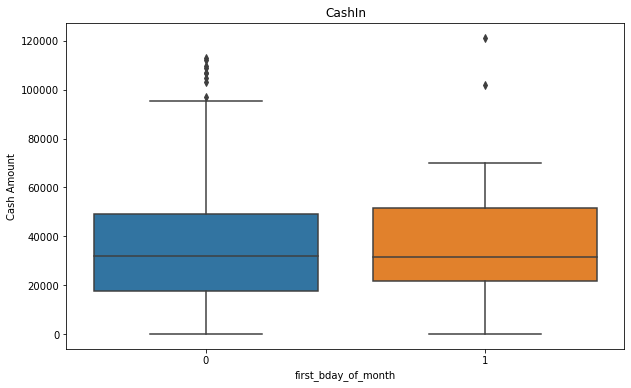

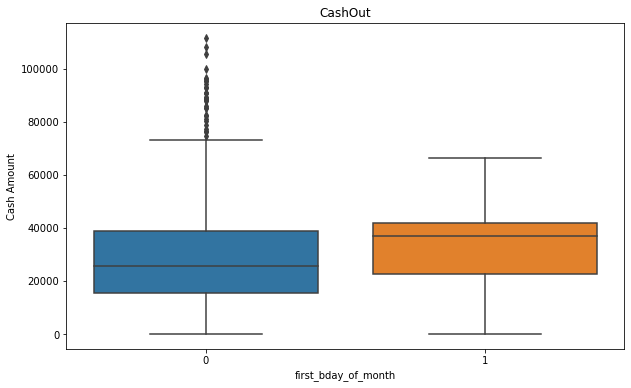

In [1606]:
for col in ['CashIn', 'CashOut']:
    plot_new_col(df, col, 'first_bday_of_month')

In [1607]:
df[df.first_bday_of_month==1]

,Date,CashIn,CashOut,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,day_nr,month_nr,year_nr,week_of_month,first_bday_of_month
0,2016-01-01,0.0,6500.0,1,1,0,0,0,0,0,0,1,1,2016,1,1
31,2016-02-01,35310.0,3410.0,1,0,1,0,0,0,0,0,1,2,2016,1,1
60,2016-03-01,31610.0,25390.0,1,0,0,0,0,0,1,0,1,3,2016,1,1
91,2016-04-01,21380.0,40060.0,1,1,0,0,0,0,0,0,1,4,2016,1,1
122,2016-05-02,66650.0,19390.0,1,0,1,0,0,0,0,0,2,5,2016,1,1
152,2016-06-01,58400.0,37070.0,1,0,0,0,0,0,0,1,1,6,2016,1,1
182,2016-07-01,35920.0,50960.0,1,1,0,0,0,0,0,0,1,7,2016,1,1
213,2016-08-01,69870.0,38270.0,1,0,1,0,0,0,0,0,1,8,2016,1,1
244,2016-09-01,19080.0,22690.0,1,0,0,0,0,1,0,0,1,9,2016,1,1
276,2016-10-03,0.0,0.0,1,0,1,0,0,0,0,0,3,10,2016,1,1


In [1610]:
last_bday_of_month = [col for cols in lastbd_col for col in cols]

In [1611]:
df = pd.concat([df,pd.DataFrame(last_bday_of_month)], axis = 1)

In [1612]:
df.head()

,Date,CashIn,CashOut,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,day_nr,month_nr,year_nr,week_of_month,first_bday_of_month,0
0,2016-01-01,0.0,6500.0,1,1,0,0,0,0,0,0,1,1,2016,1,1,0
1,2016-01-02,0.0,23110.0,0,0,0,1,0,0,0,0,2,1,2016,1,0,0
2,2016-01-03,0.0,7070.0,0,0,0,0,1,0,0,0,3,1,2016,1,0,0
3,2016-01-04,0.0,18520.0,1,0,1,0,0,0,0,0,4,1,2016,1,0,0
4,2016-01-05,20840.0,22200.0,1,0,0,0,0,0,1,0,5,1,2016,1,0,0


In [1613]:
df.rename({df.columns[-1]: 'last_bday_of_month'}, axis=1, inplace=True)

In [1614]:
df.head()

,Date,CashIn,CashOut,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,day_nr,month_nr,year_nr,week_of_month,first_bday_of_month,last_bday_of_month
0,2016-01-01,0.0,6500.0,1,1,0,0,0,0,0,0,1,1,2016,1,1,0
1,2016-01-02,0.0,23110.0,0,0,0,1,0,0,0,0,2,1,2016,1,0,0
2,2016-01-03,0.0,7070.0,0,0,0,0,1,0,0,0,3,1,2016,1,0,0
3,2016-01-04,0.0,18520.0,1,0,1,0,0,0,0,0,4,1,2016,1,0,0
4,2016-01-05,20840.0,22200.0,1,0,0,0,0,0,1,0,5,1,2016,1,0,0


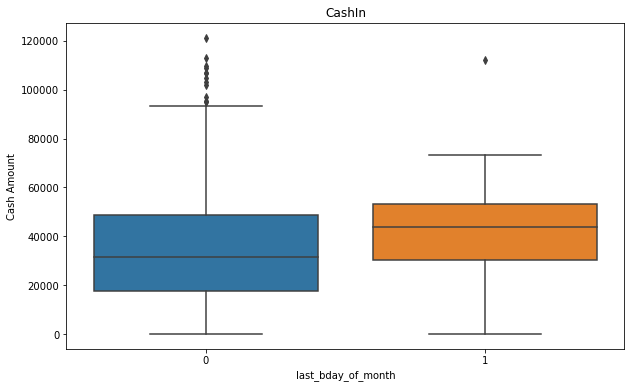

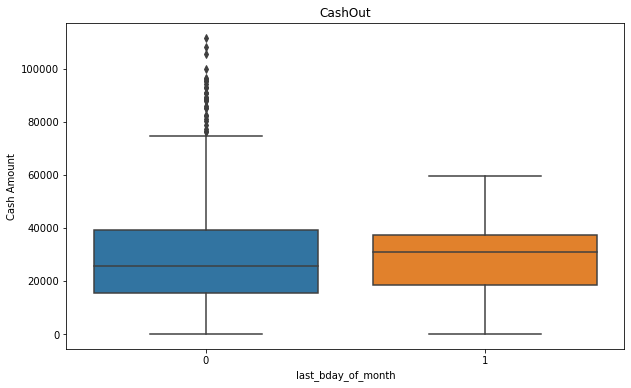

In [1615]:
for col in ['CashIn', 'CashOut']:
    plot_new_col(df, col, 'last_bday_of_month')

In [1616]:
df[df.last_bday_of_month==1].head(10)

,Date,CashIn,CashOut,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,day_nr,month_nr,year_nr,week_of_month,first_bday_of_month,last_bday_of_month
28,2016-01-29,12670.0,6760.0,1,1,0,0,0,0,0,0,29,1,2016,5,0,1
59,2016-02-29,43120.0,18260.0,1,0,1,0,0,0,0,0,29,2,2016,5,0,1
90,2016-03-31,32100.0,17480.0,1,0,0,0,0,1,0,0,31,3,2016,5,0,1
119,2016-04-29,34090.0,37260.0,1,1,0,0,0,0,0,0,29,4,2016,5,0,1
151,2016-05-31,22170.0,18350.0,1,0,0,0,0,0,1,0,31,5,2016,5,0,1
181,2016-06-30,59610.0,49090.0,1,0,0,0,0,1,0,0,30,6,2016,5,0,1
210,2016-07-29,2750.0,7780.0,1,1,0,0,0,0,0,0,29,7,2016,5,0,1
243,2016-08-31,44610.0,14460.0,1,0,0,0,0,0,0,1,31,8,2016,5,0,1
273,2016-09-30,0.0,0.0,1,1,0,0,0,0,0,0,30,9,2016,5,0,1
304,2016-10-31,54150.0,27200.0,1,0,1,0,0,0,0,0,31,10,2016,5,0,1


In [1617]:
# convert year nr to dummy with 30 variables
df = pd.concat([df, pd.get_dummies(df.year_nr, prefix = 'year_')], axis=1).drop(['year_nr'], axis=1)

In [1618]:
# convert month nr to dummy with 30 variables
df = pd.concat([df, pd.get_dummies(df.month_nr, prefix = 'month_')], axis=1).drop(['month_nr'], axis=1)

In [1619]:
# convert day nr to dummy with 30 variables
df = pd.concat([df, pd.get_dummies(df.day_nr, prefix = 'day_')], axis=1).drop(['day_nr'], axis=1)

In [1620]:
# convert week nr to dummy with 30 variables
df = pd.concat([df, pd.get_dummies(df.week_of_month, prefix = 'week_')], axis=1).drop(['week_of_month'], axis=1)

In [1621]:
df.shape

(1216, 65)

In [1622]:
df.head()

,Date,CashIn,CashOut,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,...,day__27,day__28,day__29,day__30,day__31,week__1,week__2,week__3,week__4,week__5
0,2016-01-01,0.0,6500.0,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,2016-01-02,0.0,23110.0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,2016-01-03,0.0,7070.0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,2016-01-04,0.0,18520.0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,2016-01-05,20840.0,22200.0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


## Time Series Methods

Under this subtopic AutoRegressive Integrated Moving Average (ARIMA) approach will be integrated to forecast cash demands. 

According to this method, time series can be broken down into 3 components.

- Trend: Upward & downward movement of the data with time over a period of time 
- Seasonality: Seasonal variance 
- Noise: Spikes & troughs at random intervals

But before implementation of this algorithm it is needed to be ensure that the dataset is stationary, which means it is expected from time series to keep its mean, variance and covariance constant over time. If a time series is stationary, then it is safe to assume that it will have same behaviour at some later point in time.

Firstly, I will split train and validation sets manually. As it is remembered the dataset contains 3 years plus 3 months observations, so I split 3 years as train and rest as validation for this part.  



In [1623]:
df[df.Date == '2019-01-01']

,Date,CashIn,CashOut,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,...,day__27,day__28,day__29,day__30,day__31,week__1,week__2,week__3,week__4,week__5
1096,2019-01-01,27510.0,19440.0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [1624]:
time = range(len(df_init.Date))
CI_Series = df_init.CashIn
CO_Series = df_init.CashOut

split_time = 1096
time_train = df_init.Date[:split_time]
CI_train = df_init.CashIn[:split_time]
CO_train = df_init.CashOut[:split_time]

time_valid = df_init.Date[split_time:]
CI_valid = df_init.CashIn[split_time:]
CO_valid = df_init.CashOut[split_time:]

In [1625]:
def plot_series(time, series, format="-"):
    plt.plot(time, series, format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

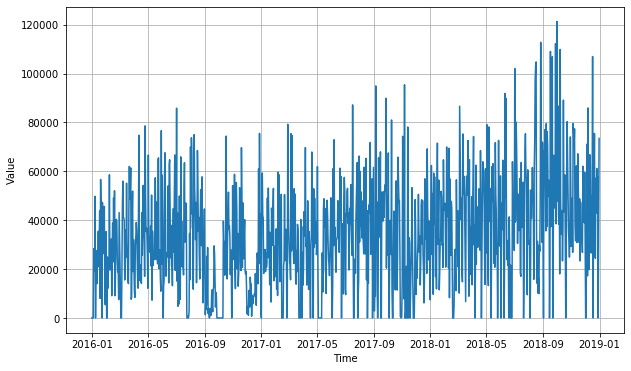

In [1626]:
plt.figure(figsize=(10, 6))
plot_series(time_train, CI_train)
plt.show()

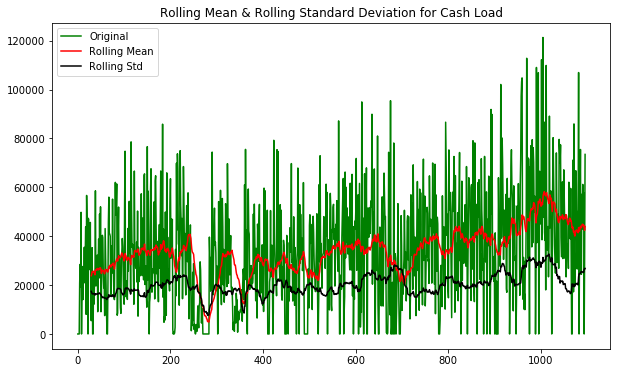

In [1627]:
rolling_mean = CI_train.rolling(window = 30).mean()
rolling_std = CI_train.rolling(window = 30).std()

plt.figure(figsize=(10, 6))
plt.plot(CI_train, color = 'green', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation for Cash Load')
plt.show()

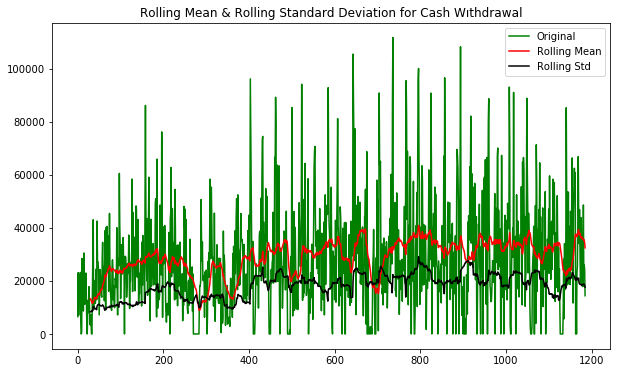

In [1628]:
rolling_mean = CO_Series.rolling(window = 30).mean()
rolling_std = CO_Series.rolling(window = 30).std()

plt.figure(figsize=(10, 6))
plt.plot(CO_Series, color = 'green', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation for Cash Wıthdrawal')
plt.show()

In [1629]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

In [1630]:
#testing if data is stationary
adfuller_test(CI_train)

ADF Test Statistic : -3.691802319434097
p-value : 0.0042299506225208835
#Lags Used : 21
Number of Observations : 1074


In [1631]:
#testing if data is stationary
adfuller_test(CO_train)

ADF Test Statistic : -6.180226311051346
p-value : 6.482142439409857e-08
#Lags Used : 20
Number of Observations : 1075


I assumed both datasets are stationary from the rolling average differences and adfuller test p-value results above. Adfuller method tests the null hypothesis which claims that data is not stationary if H0 is True. And base on the p-value results according to 0.05 alpha level, we reject the null hypothesis which helps us to consider both datasets as stationary.
If it found out as non-stationary, there are several apporaches to transform series to stationary data such as get differences by time or aking logarithm of series or even taking log-returns by getting differences of logarithm of series.

So I can implement ARIMA now. Three integers (p, d, q) are typically used to parametrize ARIMA models. To understand these parameters firstly it will be useful to split ARIMA to 3 parts. AR refers to Autoregressive models which operate under the premise that past values have an effect on current values. Moving Average Model (MA) assumes the value of the dependent variable on the current day depends on the previous days error terms. Combination of the AR and MA models is called ARMA and ARIMA model adds differencing to an ARMA model.

          p: number of autoregressive terms (AR order)
          d: number of nonseasonal differences (differencing order)
          q: number of moving-average terms (MA order)
          
To determine these parameters I will plot Autocorrelation Funtion(ACF) and Partial Autocorrelation Funtion(PACF) to find out if there are splikes jump over alpha level.  
According to these graphs, if there is a clear spike at the beggining lags of ACF plot, it refers to the order of MA(q), similarly spikes in PACF plot refers to the order of AR(p).

### ARIMA for CashIn

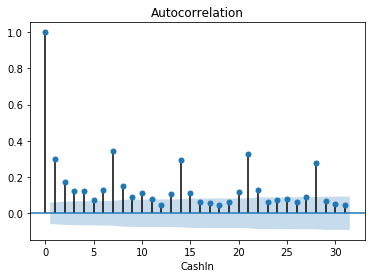

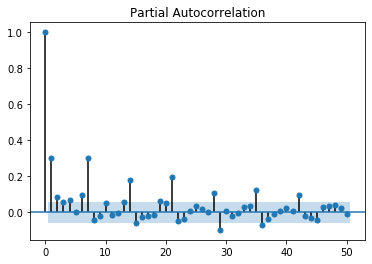

In [1632]:
plot_acf(CI_train)
plt.xlabel('CashIn')
plt.show()

plot_pacf(CI_train, lags=50)
plt.show()

In [1633]:
warnings.filterwarnings("ignore")
aic =100000
for p in range(5):
    for q in range(5):
        for d in range(0,2):
            if (p+q+d)<=6:
                model = ARIMA(CI_train, order=(p,d,q))
                results = model.fit(disp=-1)
                print(p,d,q, results.aic, results.bic)
                if results.aic < aic:
                    aic = results.aic 
#plt.plot(df.CashIn)
#plt.plot(results.fittedvalues, color='red')
aic

0 0 0 25054.659593820248 25064.658438755265
0 1 0 25395.03141817823 25405.02843746273
0 0 1 24971.417652156768 24986.41591955929
0 1 1 24910.403234290658 24925.39876321741
0 0 2 24955.66203117017 24975.659721040203
0 1 2 24876.633418123616 24896.62745669262
0 0 3 24950.8460635296 24975.84317586714
0 1 3 24875.44016576459 24900.432713975842
0 0 4 24944.251185994475 24974.24772079952
0 1 4 24877.440165073887 24907.43122292739
1 0 0 24951.79149104195 24966.789758444473
1 1 0 25199.746563431996 25214.74209235875
1 0 1 24924.876524843086 24944.87421471312
1 1 1 24873.753797286678 24893.74783585568
1 0 2 24897.583034228704 24922.580146566244
1 1 2 24875.508005962685 24900.500554173937
1 0 3 24897.278137682628 24927.274672487674
1 1 3 24877.143871273744 24907.134929127245
1 0 4 24899.147615491078 24934.143572763634
1 1 4 24879.139550239946 24914.1291177357
2 0 0 24945.212429305342 24965.210119175375
2 1 0 25118.509213396228 25138.50325196523
2 0 1 24895.586768670022 24920.583881007562
2 1 1 2

24863.002756263264

                             ARIMA Model Results                              
Dep. Variable:               D.CashIn   No. Observations:                 1095
Model:                 ARIMA(2, 1, 3)   Log Likelihood              -12424.501
Method:                       css-mle   S.D. of innovations          20465.636
Date:                Mon, 15 Feb 2021   AIC                          24863.003
Time:                        16:37:01   BIC                          24897.992
Sample:                             1   HQIC                         24876.243
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             22.1371     29.675      0.746      0.456     -36.026      80.300
ar.L1.D.CashIn    -0.7491      0.080     -9.388      0.000      -0.906      -0.593
ar.L2.D.CashIn    -0.6656      0.067

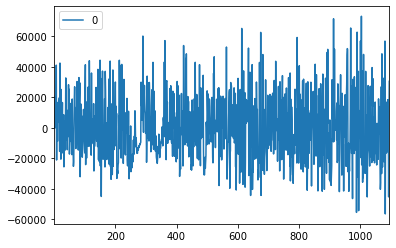

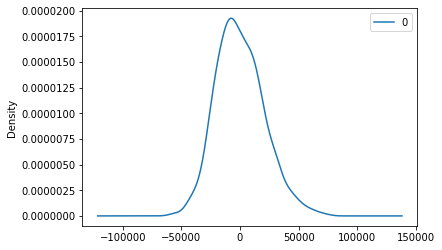

In [1634]:
# fit model
model = ARIMA(CI_train, order=(2,1,3))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()


From the graphs generated with residuals of the fitted model, I would expect white noise with zero mean distribution to see how good the fitted model is. Although, the fitted model results are not good as expected because of small bias in the prediction, I will end this section by using this model for prediction. 

In [1635]:
CI_valid.index

RangeIndex(start=1096, stop=1186, step=1)

In [1636]:
predictions = model_fit.predict(start=1096, end=1185)
predictions = np.where(predictions<0,0,predictions)
for t in range(5):
    print('predicted = ', predictions[t], 'expected = ' , CI_valid.values[t])

rmse = sqrt(mean_squared_error(CI_valid, predictions))
mae = mean_absolute_error(CI_valid, predictions)
print('Test RMSE: ' , rmse)
print('Test MAE: ' , mae)

predicted =  0.0 expected =  27510.0
predicted =  0.0 expected =  58800.0
predicted =  0.0 expected =  57580.0
predicted =  8774.7144114897 expected =  39090.0
predicted =  0.0 expected =  57920.0
Test RMSE:  43786.13957127134
Test MAE:  37309.66410913346


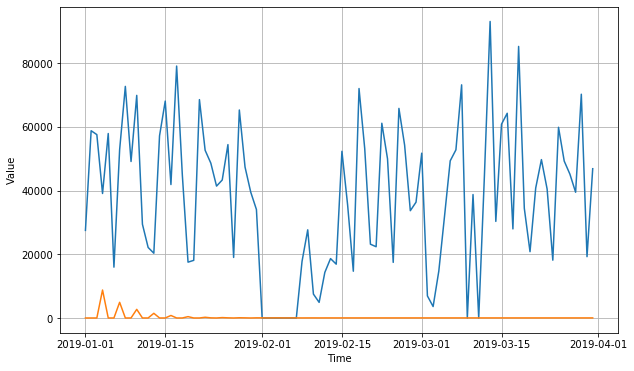

In [1637]:
plt.figure(figsize=(10, 6))
plot_series(time_valid.values, CI_valid.values)
plot_series(time_valid.values, predictions)

It is claimed from the prediction results based on CashIn values, the trained model assumes that the ATM will not need any extra Cash in and will create its own money some time later 🙂 <br>
Or as a serious answer, this appoach did not work well to forecast future cash needs of the ATM, so it is better to continue rather than trying to improve results. 


#### ARIMA for CashOut

In [1638]:
#testing if data is stationary
adfuller_test(CO_train)

ADF Test Statistic : -6.180226311051346
p-value : 6.482142439409857e-08
#Lags Used : 20
Number of Observations : 1075


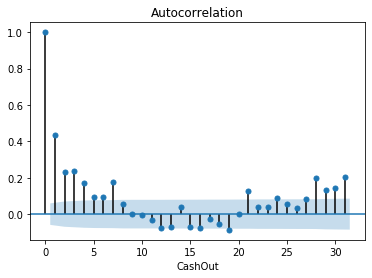

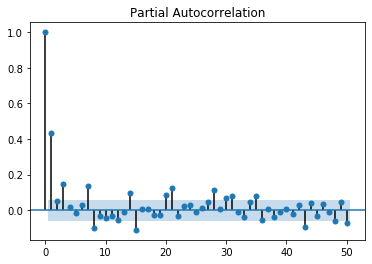

In [1639]:
plot_acf(CO_train)
plt.xlabel('CashOut')
plt.show()

plot_pacf(CO_train, lags=50)
plt.show()

In [1640]:
warnings.filterwarnings("ignore")
aic =100000
for p in range(5):
    for q in range(5):
        for d in range(0,2):
            if (p+q+d)<6:
                model = ARIMA(CO_train, order=(p,d,q))
                results = model.fit(disp=-1)
                print(p,d,q, results.aic, results.bic)
                if results.aic < aic:
                    aic = results.aic 

aic

0 0 0 24762.935393396278 24772.934238331294
0 1 0 24872.18799788681 24882.18501717131
0 0 1 24568.52049180012 24583.518759202645
0 1 1 24604.90482909866 24619.900358025414
0 0 2 24556.230337381072 24576.228027251105
0 1 2 24523.994852871747 24543.98889144075
0 0 3 24529.689958209725 24554.687070547265
0 1 3 24515.822177265738 24540.81472547699
0 0 4 24520.48623255456 24550.482767359605
0 1 4 24494.343701815385 24524.334759668887
1 0 0 24533.827007098636 24548.82527450116
1 1 0 24756.634197589716 24771.62972651647
1 0 1 24527.9561783296 24547.953868199635
1 1 1 24499.535083416846 24519.529121985848
1 0 2 24515.56201891391 24540.55913125145
1 1 2 24498.086881591928 24523.07942980318
1 0 3 24512.776253039498 24542.772787844544
1 1 3 24488.719930421736 24518.710988275237
1 0 4 24514.36192276619 24549.357880038748
2 0 0 24532.84826387361 24552.845953743643
2 1 0 24639.560821688006 24659.55486025701
2 0 1 24521.363696382767 24546.360808720307
2 1 1 24500.20599079569 24525.198539006942
2 0 2 

24460.22188358869

                              ARMA Model Results                              
Dep. Variable:                CashOut   No. Observations:                 1096
Model:                     ARMA(3, 2)   Log Likelihood              -12223.111
Method:                       css-mle   S.D. of innovations          16854.930
Date:                Mon, 15 Feb 2021   AIC                          24460.222
Time:                        16:37:19   BIC                          24495.218
Sample:                             0   HQIC                         24473.463
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.841e+04    966.218     29.401      0.000    2.65e+04    3.03e+04
ar.L1.CashOut     0.0391      0.027      1.442      0.149      -0.014       0.092
ar.L2.CashOut    -0.7829      0.012    -

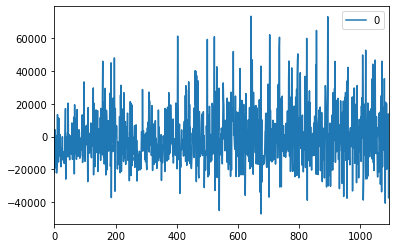

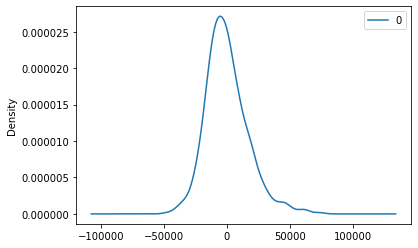

In [1641]:
# fit model
model = ARIMA(CO_train, order=(3,0,2))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
# density plot of residuals
residuals.plot(kind='kde')
plt.show()


From the graphs generated with residuals of the fitted model, I would expect white noise with zero mean distribution to see how good the fitted model is. Although, the fitted model results are not good as expected because of small bias in the prediction, I will end this section by using this model for prediction. 

In [1642]:
CO_valid.index

RangeIndex(start=1096, stop=1186, step=1)

In [1643]:
predictions = model_fit.predict(start=1096, end=1185)
predictions = np.where(predictions<0,0,predictions)

for t in range(5):
    print('predicted = ', predictions[t], 'expected = ' , CI_valid.values[t])

rmse = sqrt(mean_squared_error(CO_valid, predictions))
mae = mean_absolute_error(CO_valid, predictions)
print('Test RMSE: ' , rmse)
print('Test MAE: ' , mae)

predicted =  33524.89823783943 expected =  27510.0
predicted =  23139.386151612925 expected =  58800.0
predicted =  25918.353911366674 expected =  57580.0
predicted =  34889.32622728995 expected =  39090.0
predicted =  28083.145388530305 expected =  57920.0
Test RMSE:  17767.513159836642
Test MAE:  13926.141587680342


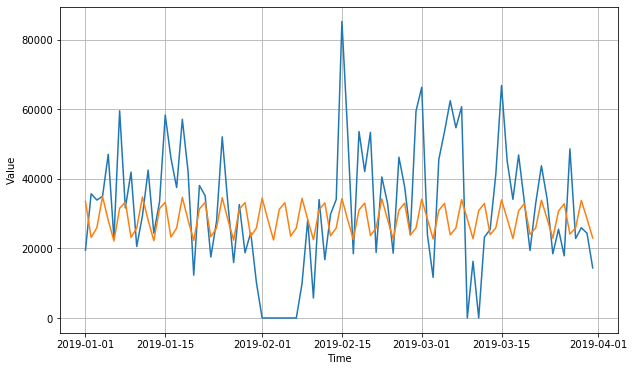

In [1644]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, CO_valid)
plot_series(time_valid, predictions)

Predictions of this model is also not successful enough to be used in the final stage. From now on, I will skip this appoach and jump into the next one. 

## Predictions with LSTM 

Under this subtopic, I will apply LSTM to the series data, only by using 30 days window values as predictors.

### LSTM for CashIn

In [1645]:
df[df.Date == '2019-01-01']

,Date,CashIn,CashOut,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,...,day__27,day__28,day__29,day__30,day__31,week__1,week__2,week__3,week__4,week__5
1096,2019-01-01,27510.0,19440.0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0


In [1646]:
split_time = 1096
time_train = df_init.Date[:split_time]
CI_train = df_init.CashIn[:split_time]
CO_train = df_init.CashOut[:split_time]

time_valid = df_init.Date[split_time:]
CI_valid = df_init.CashIn[split_time:]
CO_valid = df_init.CashOut[split_time:]

In [1647]:
train = []
y = []
window_size = 10
for i in range(window_size,len(CI_train)):
    train.append(CI_train[i-window_size:i])
    y.append(CI_train[i])

In [1648]:
train = np.array(train)
train = train[:,:, np.newaxis]
y = np.array(y).reshape(-1,1)
print('train shape : ', train.shape,'y shape : ', y.shape)

train shape :  (1086, 10, 1) y shape :  (1086, 1)


In [1649]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(60,return_sequences = True, input_shape=(window_size,1)),
    tf.keras.layers.LSTM(60,  return_sequences = False),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [1650]:
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 10, 60)            14880     
_________________________________________________________________
lstm_48 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_75 (Dense)             (None, 128)               7808      
_________________________________________________________________
dense_76 (Dense)             (None, 1)                 129       
Total params: 51,857
Trainable params: 51,857
Non-trainable params: 0
_________________________________________________________________


In [1651]:
model.fit(x = train,y = y, epochs = 20, batch_size =1)

Epoch 1/20
1086/1086 [==============================] - 5s 3ms/step - loss: 1619061287.4186 - mse: 1619061287.4186
Epoch 2/20
1086/1086 [==============================] - 3s 3ms/step - loss: 798113639.1536 - mse: 798113639.1536
Epoch 3/20
1086/1086 [==============================] - 3s 3ms/step - loss: 509319571.7829 - mse: 509319571.7829
Epoch 4/20
1086/1086 [==============================] - 3s 3ms/step - loss: 497166402.7452 - mse: 497166402.7452
Epoch 5/20
1086/1086 [==============================] - 3s 3ms/step - loss: 433646884.1987 - mse: 433646884.1987
Epoch 6/20
1086/1086 [==============================] - 3s 3ms/step - loss: 488526692.1509 - mse: 488526692.1509
Epoch 7/20
1086/1086 [==============================] - 3s 3ms/step - loss: 437285151.3671 - mse: 437285151.3671
Epoch 8/20
1086/1086 [==============================] - 3s 3ms/step - loss: 432238695.5658 - mse: 432238695.5658
Epoch 9/20
1086/1086 [==============================] - 3s 3ms/step - loss: 486377359.1021 - m

In [1652]:
test = []
ytest = []
for i in range(10, len(CI_valid)):
    test.append(np.array(CI_valid)[i-10:i])
    ytest.append(np.array(CI_valid)[i])

In [1653]:
test = np.array(test)[:,:, np.newaxis]
ytest = np.array(ytest).reshape(-1,1)
print('train shape : ', test.shape,'y shape : ', ytest.shape)

train shape :  (80, 10, 1) y shape :  (80, 1)


In [1654]:
forecast = model.predict(test)

Test RMSE is : 22830.788712079466
Test MAE is : 19293.42529296875


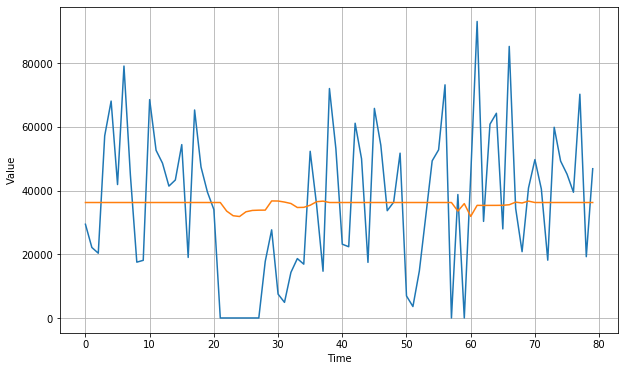

In [1655]:
rmse = sqrt(mean_squared_error(ytest, forecast))
mae = mean_absolute_error(ytest, forecast)
print('Test RMSE is :' , rmse)
print('Test MAE is :' , mae)
plt.figure(figsize=(10, 6))
plot_series(range(len(forecast)), ytest)
plot_series(range(len(forecast)), forecast)

Changing window size or other keras parameters would have impacts on prediction in positive way, but I will skip this to build a NN model for predictions.

### LSTM for CashOut

In [1656]:
train = []
y = []
window_size = 10
for i in range(window_size,len(CO_train)):
    train.append(CO_train[i-window_size:i])
    y.append(CO_train[i])

In [1657]:
train = np.array(train)
train = train[:,:, np.newaxis]
y = np.array(y).reshape(-1,1)
print('train shape : ', train.shape,'y shape : ', y.shape)

train shape :  (1086, 10, 1) y shape :  (1086, 1)


In [1658]:
del(model)

In [1659]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(60,return_sequences = True, input_shape=(window_size,1)),
    tf.keras.layers.LSTM(60,  return_sequences = False),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mse'])

In [1660]:
model.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_49 (LSTM)               (None, 10, 60)            14880     
_________________________________________________________________
lstm_50 (LSTM)               (None, 60)                29040     
_________________________________________________________________
dense_77 (Dense)             (None, 128)               7808      
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 129       
Total params: 51,857
Trainable params: 51,857
Non-trainable params: 0
_________________________________________________________________


In [1661]:
model.fit(x = train,y = y, epochs = 20)

Epoch 1/20
34/34 [==============================] - 2s 6ms/step - loss: 1166291569.3714 - mse: 1166291569.3714
Epoch 2/20
34/34 [==============================] - 0s 6ms/step - loss: 1200565494.8571 - mse: 1200565494.8571
Epoch 3/20
34/34 [==============================] - 0s 6ms/step - loss: 1136972344.6857 - mse: 1136972344.6857
Epoch 4/20
34/34 [==============================] - 0s 6ms/step - loss: 1209165776.4571 - mse: 1209165776.4571
Epoch 5/20
34/34 [==============================] - 0s 6ms/step - loss: 1137377124.5714 - mse: 1137377124.5714
Epoch 6/20
34/34 [==============================] - 0s 6ms/step - loss: 1081337024.0000 - mse: 1081337024.0000
Epoch 7/20
34/34 [==============================] - 0s 6ms/step - loss: 1244753312.9143 - mse: 1244753312.9143
Epoch 8/20
34/34 [==============================] - 0s 6ms/step - loss: 1102919802.5143 - mse: 1102919802.5143
Epoch 9/20
34/34 [==============================] - 0s 6ms/step - loss: 1127235765.0286 - mse: 1127235765.0286
E

In [1662]:
test = []
ytest = []
for i in range(10, len(CO_valid)):
    test.append(np.array(CO_valid)[i-10:i])
    ytest.append(np.array(CO_valid)[i])

In [1663]:
test = np.array(test)[:,:, np.newaxis]
ytest = np.array(ytest).reshape(-1,1)
print('train shape : ', test.shape,'y shape : ', ytest.shape)

train shape :  (80, 10, 1) y shape :  (80, 1)


In [1664]:
forecast = model.predict(test)

Test RMSE is : 29302.035137576342
Test MAE is : 24382.90360107422


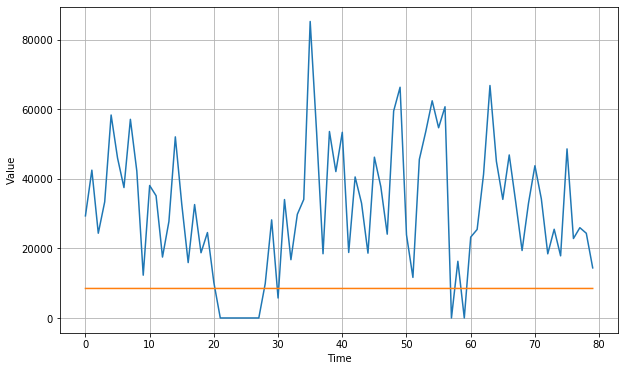

In [1665]:
rmse = sqrt(mean_squared_error(ytest, forecast))
mae = mean_absolute_error(ytest, forecast)
print('Test RMSE is :' , rmse)
print('Test MAE is :' , mae)
plt.figure(figsize=(10, 6))
plot_series(range(len(forecast)), ytest)
plot_series(range(len(forecast)), forecast)

## Supervised Learning Methods

Under this subtopic, timeseries data will be treated as static data and supervised models will be implemented to predict future values. To do this, I will make a copy of the original data, then I will add previous 3 day's value as feature. After this implementation, since the first value in the first observation has not followed by a previous observation in terms of CashIn amounts, need to be renounced. 

### ML for CashIn

In [1666]:
df1 = df.copy()

In [1667]:
df1['CashIn_t3'] = df1.CashIn.shift(3)
df1['CashIn_t2'] = df1.CashIn.shift(2)
df1['CashIn_t1'] = df1.CashIn.shift(1)


In [1668]:
df1 = df1[ [col for col in df1.columns if col != 'CashIn'] + ['CashIn'] ]

In [1669]:
df1[['CashIn', 'CashIn_t1', 'CashIn_t2','CashIn_t3']].head(8)

,CashIn,CashIn_t1,CashIn_t2,CashIn_t3
0,0.0,NaN,NaN,NaN
1,0.0,0.0,NaN,NaN
2,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0
4,20840.0,0.0,0.0,0.0
5,28460.0,20840.0,0.0,0.0
6,19250.0,28460.0,20840.0,0.0
7,49770.0,19250.0,28460.0,20840.0


In [1670]:
df1.dropna(inplace=True)
df1 = df1.reset_index(drop=True)

In [1671]:
df1[df1.Date == '2019-01-01']

,Date,CashOut,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,...,day__31,week__1,week__2,week__3,week__4,week__5,CashIn_t3,CashIn_t2,CashIn_t1,CashIn
1093,2019-01-01,19440.0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0.0,31670.0,73460.0,27510.0


In [1672]:
df1.drop(['Date', 'CashOut', ], axis=1, inplace = True)

In [1673]:
split_time = 1093
X_train = df1[:split_time]
X_test = df1[split_time:]


In [1674]:
X_test.iloc[:,:-1]

,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,first_bday_of_month,last_bday_of_month,...,day__30,day__31,week__1,week__2,week__3,week__4,week__5,CashIn_t3,CashIn_t2,CashIn_t1
1093,1,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0.0,31670.0,73460.0
1094,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,31670.0,73460.0,27510.0
1095,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,73460.0,27510.0,58800.0
1096,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,27510.0,58800.0,57580.0
1097,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,58800.0,57580.0,39090.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,18150.0,59880.0,49270.0
1179,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,59880.0,49270.0,45160.0
1180,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,49270.0,45160.0,39480.0
1181,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,45160.0,39480.0,70260.0


In [1675]:
len(X_test.iloc[:,-1])

90

Test RMSE of  DecisionTreeRegressor is : 25077.037814613504
Test MAE of  DecisionTreeRegressor is : 19852.555555555555
Test RMSE of  GradientBoostingRegressor is : 20103.8017397683
Test MAE of  GradientBoostingRegressor is : 16234.764891312036
Test RMSE of  XGBRegressor is : 22128.535273942918
Test MAE of  XGBRegressor is : 17385.48097398546


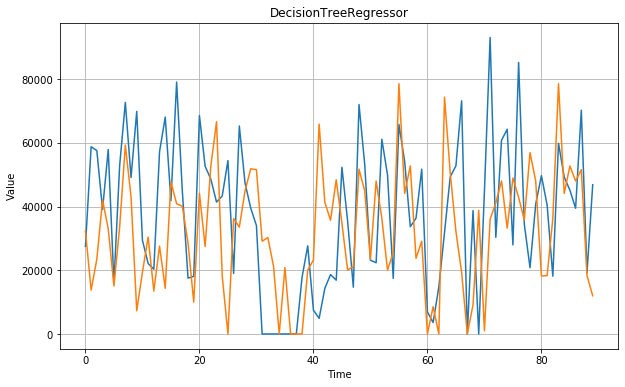

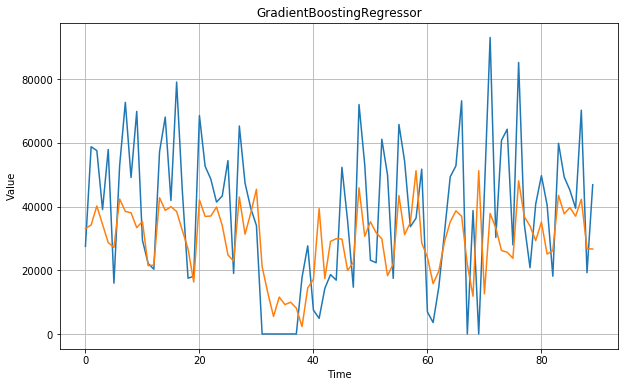

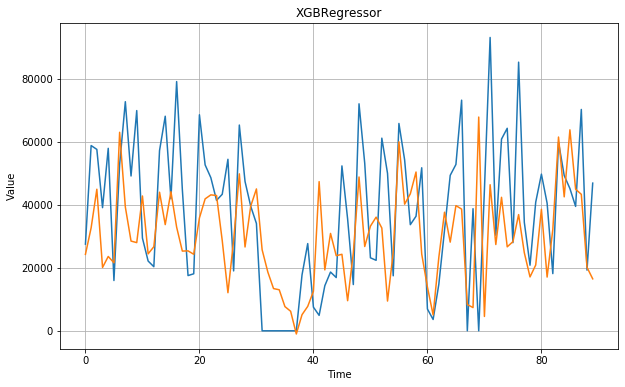

In [1676]:
models = [DecisionTreeRegressor(), GradientBoostingRegressor(), XGBRegressor()]

def model_predictions(model, X_train=X_train, X_test=X_test):
    model.fit(X_train.iloc[:,:-1], X_train.iloc[:,-1])
    yhat = model.predict(X_test.iloc[:,:-1])
    rmse = sqrt(mean_squared_error(X_test.iloc[:,-1], yhat))
    mae = mean_absolute_error(X_test.iloc[:,-1], yhat)
    print('Test RMSE of ', str(model).split('(')[0], 'is :' , rmse)
    print('Test MAE of ', str(model).split('(')[0], 'is :' , mae)
    plt.figure(figsize=(10, 6))
    plt.title(str(model).split('(')[0])
    plot_series(range(len(yhat)), X_test.iloc[:,-1])
    plot_series(range(len(yhat)), yhat)
    return model
    
for model in models:
    model_predictions(model, X_train, X_test)

According to results of the models, Gradient Boosting Regressor achieved best results in terms of its RMSE and MAE error values. And its predictions also can be observed from the graph above, which compares actual values with predictions. 

However, since CashIn_t1 feature filled with previous day's CashIn value, it won't be useable for unseen data to predict. So I will use walk forward method to predict, which will allow me to use previous days' prediction as CashIn_t1 value when predicting current day, so I can predict unseen data. I will use Gradient Boosting Regressor as final algorithm, but if I've had enough time, it would improve results to try several algorithms and also doing parameter optimization. 

In [1677]:
model = GradientBoostingRegressor()
model.fit(X_train.iloc[:,:-1], X_train.iloc[:,-1])


GradientBoostingRegressor()

In [1678]:
def walk_forward_prediction(data, model, index):
    # yhat = []
    for idx, i in enumerate(index):
        if len(yhat)==0:
            data.CashIn_t1[i] = data.CashIn[i-1] 
            data.CashIn_t2[i] = data.CashIn[i-2] 
            data.CashIn_t3[i] = data.CashIn[i-3] 
        elif len(yhat)==1:
            data.CashIn_t1[i] = yhat[idx-1]
            data.CashIn_t2[i] = data.CashIn[i-2] 
            data.CashIn_t3[i] = data.CashIn[i-3]   
        elif len(yhat)==2:
            data.CashIn_t1[i] = yhat[idx-1]
            data.CashIn_t2[i] = yhat[idx-2]
            data.CashIn_t3[i] = data.CashIn[i-3]   
        else:
            data.CashIn_t1[i] = yhat[idx-1]
            data.CashIn_t2[i] = yhat[idx-2]
            data.CashIn_t3[i] = yhat[idx-3]

        yhat.append(model.predict(np.asarray(data.iloc[i,:-1]).reshape(1, -1)))
        print('Input: ', data.iloc[i,-1],'Predicted: ' ,yhat[idx])

def walk_forward_prediction(data, model, index):
    # yhat = []
    for idx, i in enumerate(index):
        if len(yhat)==0:
            data.CashIn_t1[i] = data.CashIn[i-1] 
        else:
            data.CashIn_t1[i] = yhat[idx-1]
        yhat.append(model.predict(np.asarray(data.iloc[i,:-1]).reshape(1, -1)))
        print('Input: ', data.iloc[i,-1],'Predicted: ' ,yhat[idx])

In [1679]:
yhat = []
walk_forward_prediction(df1, model, df1[split_time:].index)

Input:  27510.0 Predicted:  [33132.50190193]
Input:  58800.0 Predicted:  [34226.28975633]
Input:  57580.0 Predicted:  [36949.87229398]
Input:  39090.0 Predicted:  [33882.24106791]
Input:  57920.0 Predicted:  [23883.49908651]
Input:  15960.0 Predicted:  [25158.98378338]
Input:  52850.0 Predicted:  [49869.80237251]
Input:  72720.0 Predicted:  [38386.5778758]
Input:  49140.0 Predicted:  [36095.64384534]
Input:  69900.0 Predicted:  [32510.06657264]
Input:  29430.0 Predicted:  [26964.48602006]
Input:  22140.0 Predicted:  [21106.41030416]
Input:  20340.0 Predicted:  [18200.983313]
Input:  57200.0 Predicted:  [41997.15627292]
Input:  68110.0 Predicted:  [38395.39597776]
Input:  41900.0 Predicted:  [38308.79193538]
Input:  79110.0 Predicted:  [36262.4283921]
Input:  44890.0 Predicted:  [24871.84002177]
Input:  17530.0 Predicted:  [16688.44179871]
Input:  18100.0 Predicted:  [16862.47337966]
Input:  68570.0 Predicted:  [42002.28847649]
Input:  52660.0 Predicted:  [36513.69194805]
Input:  48610.

In [1680]:
df1[[ 'CashIn','CashIn_t1', 'CashIn_t2', 'CashIn_t3']].tail()

,CashIn,CashIn_t1,CashIn_t2,CashIn_t3
1178,45160.0,31654.743775,43771.817747,20595.122889
1179,39480.0,35692.606767,31654.743775,43771.817747
1180,70260.0,35849.686870,35692.606767,31654.743775
1181,19250.0,31709.914894,35849.686870,35692.606767
1182,46870.0,23308.148234,31709.914894,35849.686870


In [1681]:
yhat[-5:]

[array([35692.60676738]),
 array([35849.68686995]),
 array([31709.91489385]),
 array([23308.14823351]),
 array([19634.04840699])]

Test RMSE of  GradientBoostingRegressor is : 21717.79627917609
Test MAE of  GradientBoostingRegressor is : 17526.06680992755


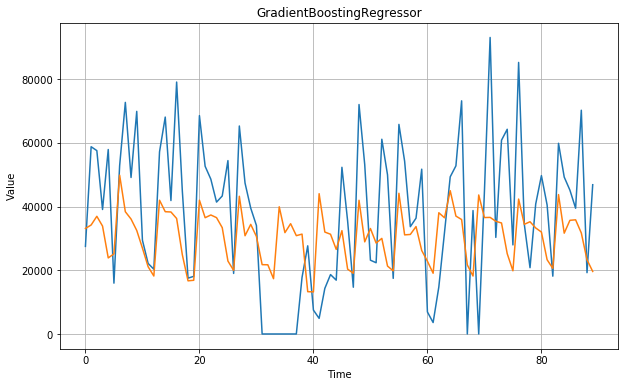

In [1682]:
rmse = sqrt(mean_squared_error(df1.iloc[split_time:,-1], yhat))
mae = mean_absolute_error(df1.iloc[split_time:,-1], yhat)
print('Test RMSE of ', str(model).split('(')[0], 'is :' , rmse)
print('Test MAE of ', str(model).split('(')[0], 'is :' , mae)
plt.figure(figsize=(10, 6))
plt.title(str(model).split('(')[0])
plot_series(range(len(yhat)), df1.iloc[split_time:,-1])
plot_series(range(len(yhat)), yhat)

Now I will try to build a DNN model to get better results. But since there are a lot of one-hot encoded features together with dense features, I will bring dense features to 0-1 range to put them same range with dummy features. 

In [1683]:
scaler = MinMaxScaler()

In [1684]:
X_train[[ 'CashIn']] = scaler.fit_transform(X_train[[ 'CashIn']])
X_train[[ 'CashIn_t1']] = scaler.fit_transform(X_train[[ 'CashIn_t1']])
X_train[[  'CashIn_t2']] = scaler.fit_transform(X_train[[ 'CashIn_t2']])
X_train[[  'CashIn_t3']] = scaler.fit_transform(X_train[[ 'CashIn_t3']])

X_test[[ 'CashIn']] = scaler.transform(X_test[[ 'CashIn']])
X_test[[ 'CashIn_t1']] = scaler.transform(X_test[[ 'CashIn_t1']])
X_test[[ 'CashIn_t2']] = scaler.transform(X_test[[ 'CashIn_t2']])
X_test[[ 'CashIn_t3']] = scaler.transform(X_test[[ 'CashIn_t3']])

In [1685]:
X_train.head()

,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,first_bday_of_month,last_bday_of_month,...,day__31,week__1,week__2,week__3,week__4,week__5,CashIn_t3,CashIn_t2,CashIn_t1,CashIn
0,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0.000000,0.000000,0.000000,0.000000
1,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0.000000,0.000000,0.000000,0.171805
2,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0.000000,0.000000,0.171805,0.234625
3,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0.000000,0.171805,0.234625,0.158697
4,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0.171805,0.234625,0.158697,0.410305


In [1686]:
del(model)

In [1687]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(365, input_shape=[X_train.shape[1]-1], activation='relu'),
    tf.keras.layers.Dense(365, activation='relu'),
    tf.keras.layers.Dense(365, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss="mse", metrics=['mse'])
model.summary()


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_79 (Dense)             (None, 365)               24090     
_________________________________________________________________
dense_80 (Dense)             (None, 365)               133590    
_________________________________________________________________
dense_81 (Dense)             (None, 365)               133590    
_________________________________________________________________
dense_82 (Dense)             (None, 1)                 366       
Total params: 291,636
Trainable params: 291,636
Non-trainable params: 0
_________________________________________________________________


In [1688]:
model.fit(X_train.iloc[:,:-1], X_train.iloc[:,-1],epochs=50)

Epoch 1/50
35/35 [==============================] - 1s 2ms/step - loss: 0.0359 - mse: 0.0359
Epoch 2/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0217 - mse: 0.0217
Epoch 3/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0190 - mse: 0.0190
Epoch 4/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0159 - mse: 0.0159
Epoch 5/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0123 - mse: 0.0123
Epoch 6/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0106 - mse: 0.0106
Epoch 7/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0095 - mse: 0.0095
Epoch 8/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0070 - mse: 0.0070
Epoch 9/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0071 - mse: 0.0071
Epoch 10/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0056 - mse: 0.0056
Epoch 11/50
35/35 [==============================] - 0s 2ms/step - lo

In [1689]:
yhat = []
walk_forward_prediction(df1, model, df1[split_time:].index)

Input:  0.22679307502061008 Predicted:  [[0.21036178]]
Input:  0.48474855729596045 Predicted:  [[0.41744506]]
Input:  0.4746908491343776 Predicted:  [[0.30779976]]
Input:  0.32225886232481454 Predicted:  [[0.29130077]]
Input:  0.47749381698268756 Predicted:  [[0.11883748]]
Input:  0.13157460840890356 Predicted:  [[0.12184882]]
Input:  0.4356966199505359 Predicted:  [[0.3884191]]
Input:  0.5995053586150042 Predicted:  [[0.36384702]]
Input:  0.40511129431162407 Predicted:  [[0.28875548]]
Input:  0.5762572135201979 Predicted:  [[0.32037744]]
Input:  0.24262159934047817 Predicted:  [[0.3603742]]
Input:  0.182522671063479 Predicted:  [[0.12032279]]
Input:  0.16768342951360266 Predicted:  [[0.15873507]]
Input:  0.47155812036273703 Predicted:  [[0.35697138]]
Input:  0.5615004122011542 Predicted:  [[0.3690112]]
Input:  0.34542456718878817 Predicted:  [[0.4695668]]
Input:  0.6521846661170652 Predicted:  [[0.4082925]]
Input:  0.3700741962077494 Predicted:  [[0.20537046]]
Input:  0.14451772464962

In [1690]:
df1.tail()

,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,first_bday_of_month,last_bday_of_month,...,day__31,week__1,week__2,week__3,week__4,week__5,CashIn_t3,CashIn_t2,CashIn_t1,CashIn
1178,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0.100043,0.435115,0.305590,0.372300
1179,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0.435115,0.305590,0.390087,0.325474
1180,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0.305590,0.390087,0.212147,0.579225
1181,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.390087,0.212147,0.260858,0.158697
1182,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0.212147,0.260858,0.223397,0.386397


In [1691]:
df1[[ 'CashIn','CashIn_t1', 'CashIn_t2', 'CashIn_t3']] = scaler.inverse_transform(df1[[ 'CashIn','CashIn_t1', 'CashIn_t2', 'CashIn_t3']])

In [1692]:
yhat = [yh for yhs in yhat for yh in yhs]


In [1693]:
yhat = scaler.inverse_transform(yhat)

Test RMSE is ; 23051.7547334646
Test MAE of is : 18430.000303347904


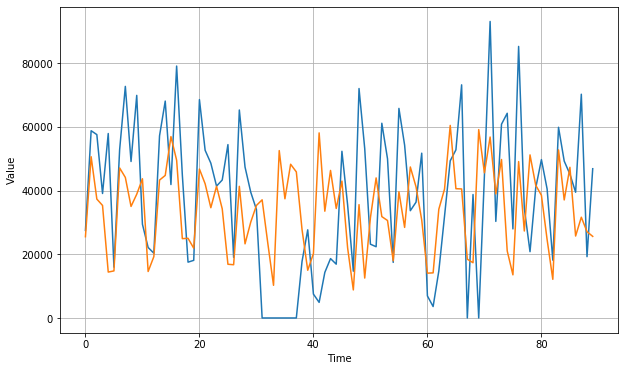

In [1694]:
rmse = sqrt(mean_squared_error(df1.iloc[split_time:,-1], yhat))
mae = mean_absolute_error(df1.iloc[split_time:,-1], yhat)
print('Test RMSE is ;', rmse)
print('Test MAE of is :' , mae)
plt.figure(figsize=(10, 6))
plot_series(range(len(yhat)), df1.iloc[split_time:,-1])
plot_series(range(len(yhat)), yhat)

### ML for CashOut

In [1695]:
df1 = df.copy()

In [1696]:
df1['CashOut_t3'] = df1.CashOut.shift(3)
df1['CashOut_t2'] = df1.CashOut.shift(2)
df1['CashOut_t1'] = df1.CashOut.shift(1)


In [1697]:
df1 = df1[ [col for col in df1.columns if col != 'CashOut'] + ['CashOut'] ]

In [1698]:
df1[['CashOut', 'CashOut_t1', 'CashOut_t2','CashOut_t3']].head(8)

,CashOut,CashOut_t1,CashOut_t2,CashOut_t3
0,6500.0,NaN,NaN,NaN
1,23110.0,6500.0,NaN,NaN
2,7070.0,23110.0,6500.0,NaN
3,18520.0,7070.0,23110.0,6500.0
4,22200.0,18520.0,7070.0,23110.0
5,18810.0,22200.0,18520.0,7070.0
6,23210.0,18810.0,22200.0,18520.0
7,4350.0,23210.0,18810.0,22200.0


In [1699]:
df1.dropna(inplace=True)
df1 = df1.reset_index(drop=True)

In [1700]:
df1[df1.Date == '2019-01-01']

,Date,CashIn,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,...,day__31,week__1,week__2,week__3,week__4,week__5,CashOut_t3,CashOut_t2,CashOut_t1,CashOut
1093,2019-01-01,27510.0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0.0,13210.0,32000.0,19440.0


In [1701]:
df1.drop(['Date', 'CashIn', ], axis=1, inplace = True)

In [1702]:
split_time = 1093
X_train = df1[:split_time]
X_test = df1[split_time:]


In [1703]:
X_test.iloc[:,:-1]

,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,first_bday_of_month,last_bday_of_month,...,day__30,day__31,week__1,week__2,week__3,week__4,week__5,CashOut_t3,CashOut_t2,CashOut_t1
1093,1,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0.0,13210.0,32000.0
1094,1,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,13210.0,32000.0,19440.0
1095,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,32000.0,19440.0,35700.0
1096,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,19440.0,35700.0,33900.0
1097,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,35700.0,33900.0,34970.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1178,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,18440.0,25500.0,17860.0
1179,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,25500.0,17860.0,48600.0
1180,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,17860.0,48600.0,22840.0
1181,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,1,48600.0,22840.0,25950.0


In [1704]:
len(X_test.iloc[:,-1])

90

Test RMSE of  DecisionTreeRegressor is : 19988.244906555563
Test MAE of  DecisionTreeRegressor is : 15234.333333333334
Test RMSE of  GradientBoostingRegressor is : 13997.624554748445
Test MAE of  GradientBoostingRegressor is : 10834.280763295903
Test RMSE of  XGBRegressor is : 15360.53925094194
Test MAE of  XGBRegressor is : 12088.628659396702


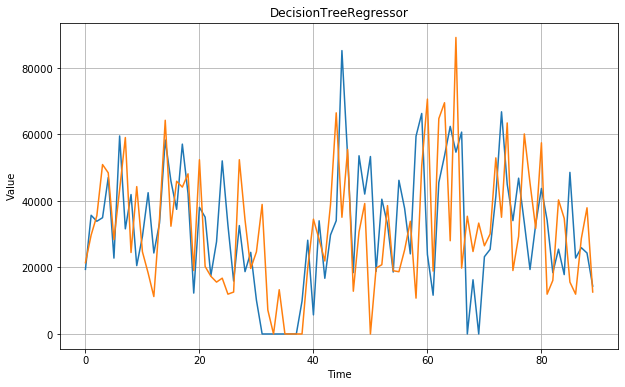

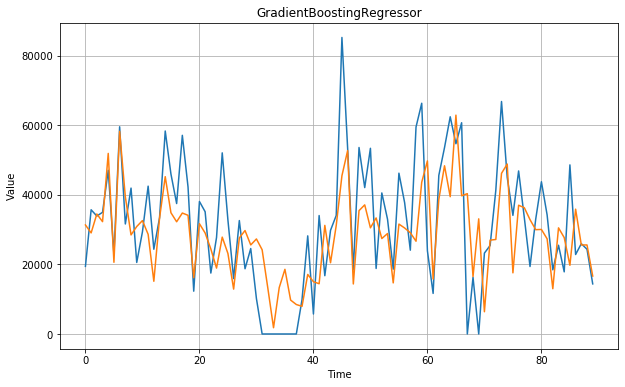

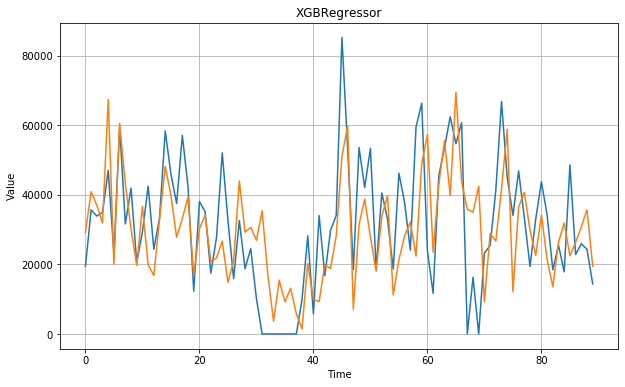

In [1705]:
models = [ DecisionTreeRegressor(), GradientBoostingRegressor(), XGBRegressor()]

def model_predictions(model, X_train=X_train, X_test=X_test):
    model.fit(X_train.iloc[:,:-1], X_train.iloc[:,-1])
    yhat = model.predict(X_test.iloc[:,:-1])
    rmse = sqrt(mean_squared_error(X_test.iloc[:,-1], yhat))
    mae = mean_absolute_error(X_test.iloc[:,-1], yhat)
    print('Test RMSE of ', str(model).split('(')[0], 'is :' , rmse)
    print('Test MAE of ', str(model).split('(')[0], 'is :' , mae)
    plt.figure(figsize=(10, 6))
    plt.title(str(model).split('(')[0])
    plot_series(range(len(yhat)), X_test.iloc[:,-1])
    plot_series(range(len(yhat)), yhat)
    return model
    
for model in models:
    model_predictions(model, X_train, X_test)

According to results of the models, again Gradient Boosting Regressor achieved best results in terms of its RMSE and MAE error values. And its predictions also can be observed from the graph above, which compares actual values with predictions. 

Now again I will implement walk forward prediction method to see its performance for further comparison. 

In [1706]:
model = GradientBoostingRegressor()
model.fit(X_train.iloc[:,:-1], X_train.iloc[:,-1])


GradientBoostingRegressor()

In [1707]:
def walk_forward_prediction(data, model, index):
    # yhat = []
    for idx, i in enumerate(index):
        if len(yhat)==0:
            data.CashOut_t1[i] = data.CashOut[i-1] 
            data.CashOut_t2[i] = data.CashOut[i-2] 
            data.CashOut_t3[i] = data.CashOut[i-3] 
        elif len(yhat)==1:
            data.CashOut_t1[i] = yhat[idx-1]
            data.CashOut_t2[i] = data.CashOut[i-2] 
            data.CashOut_t3[i] = data.CashOut[i-3]   
        elif len(yhat)==2:
            data.CashOut_t1[i] = yhat[idx-1]
            data.CashOut_t2[i] = yhat[idx-2]
            data.CashOut_t3[i] = data.CashOut[i-3]   
        else:
            data.CashOut_t1[i] = yhat[idx-1]
            data.CashOut_t2[i] = yhat[idx-2]
            data.CashOut_t3[i] = yhat[idx-3]

        yhat.append(model.predict(np.asarray(data.iloc[i,:-1]).reshape(1, -1)))
        print('Input: ', data.iloc[i,-1],'Predicted: ' ,yhat[idx])

In [1708]:
yhat = []
walk_forward_prediction(df1, model, df1[split_time:].index)

Input:  19440.0 Predicted:  [31334.16167188]
Input:  35700.0 Predicted:  [32619.46317252]
Input:  33900.0 Predicted:  [33560.57582218]
Input:  34970.0 Predicted:  [37853.00212895]
Input:  47050.0 Predicted:  [51899.1870864]
Input:  22820.0 Predicted:  [22042.13679751]
Input:  59560.0 Predicted:  [59195.20503392]
Input:  31620.0 Predicted:  [39818.17699896]
Input:  41930.0 Predicted:  [29194.84511322]
Input:  20560.0 Predicted:  [29901.63748902]
Input:  29350.0 Predicted:  [35691.30848278]
Input:  42490.0 Predicted:  [27393.11092887]
Input:  24360.0 Predicted:  [14268.7704193]
Input:  33380.0 Predicted:  [29610.91407281]
Input:  58340.0 Predicted:  [45072.84276599]
Input:  45980.0 Predicted:  [32167.26944884]
Input:  37490.0 Predicted:  [28933.09494597]
Input:  57100.0 Predicted:  [31633.6009711]
Input:  42240.0 Predicted:  [29479.10298992]
Input:  12300.0 Predicted:  [13963.54607358]
Input:  38080.0 Predicted:  [29204.87037835]
Input:  35140.0 Predicted:  [27304.54295007]
Input:  17510

Test RMSE of  GradientBoostingRegressor is : 17685.585462727722
Test MAE of  GradientBoostingRegressor is : 12910.461261712762


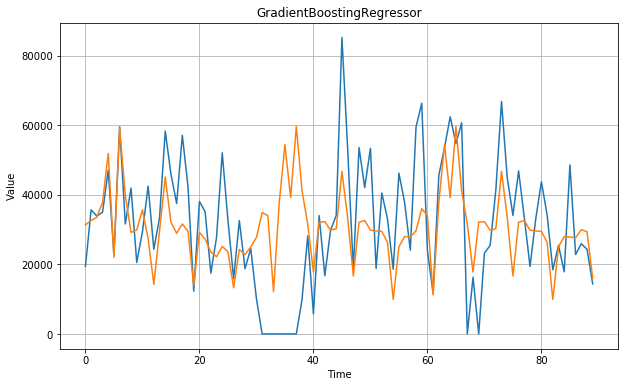

In [1709]:
rmse = sqrt(mean_squared_error(X_test.iloc[:,-1], yhat))
mae = mean_absolute_error(X_test.iloc[:,-1], yhat)
print('Test RMSE of ', str(model).split('(')[0], 'is :' , rmse)
print('Test MAE of ', str(model).split('(')[0], 'is :' , mae)
plt.figure(figsize=(10, 6))
plt.title(str(model).split('(')[0])
plot_series(range(len(yhat)), X_test.iloc[:,-1])
plot_series(range(len(yhat)), yhat)

Now I will try to build a DNN model to get better results. But since there are a lot of one-hot encoded features together with dense features, I will bring dense features to 0-1 range to put them same range with dummy features. 

In [1710]:
scaler = MinMaxScaler()

In [1711]:
X_train[[ 'CashOut']] = scaler.fit_transform(X_train[[ 'CashOut']])
X_train[[ 'CashOut_t1']] = scaler.fit_transform(X_train[[ 'CashOut_t1']])
X_train[[  'CashOut_t2']] = scaler.fit_transform(X_train[[ 'CashOut_t2']])
X_train[[  'CashOut_t3']] = scaler.fit_transform(X_train[[ 'CashOut_t3']])

X_test[[ 'CashOut']] = scaler.transform(X_test[[ 'CashOut']])
X_test[[ 'CashOut_t1']] = scaler.transform(X_test[[ 'CashOut_t1']])
X_test[[ 'CashOut_t2']] = scaler.transform(X_test[[ 'CashOut_t2']])
X_test[[ 'CashOut_t3']] = scaler.transform(X_test[[ 'CashOut_t3']])

In [1712]:
X_train.head()

,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,first_bday_of_month,last_bday_of_month,...,day__31,week__1,week__2,week__3,week__4,week__5,CashOut_t3,CashOut_t2,CashOut_t1,CashOut
0,1,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0.058192,0.206893,0.063295,0.165801
1,1,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0.206893,0.063295,0.165801,0.198747
2,1,0,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0.063295,0.165801,0.198747,0.168397
3,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0.165801,0.198747,0.168397,0.207789
4,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0.198747,0.168397,0.207789,0.038944


In [1713]:
del(model)

In [1714]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(365, input_shape=[X_train.shape[1]-1], activation='relu'),
    tf.keras.layers.Dense(365, activation='relu'),
    tf.keras.layers.Dense(365, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss="mse", metrics=['mse'])
model.summary()


Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_83 (Dense)             (None, 365)               24090     
_________________________________________________________________
dense_84 (Dense)             (None, 365)               133590    
_________________________________________________________________
dense_85 (Dense)             (None, 365)               133590    
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 366       
Total params: 291,636
Trainable params: 291,636
Non-trainable params: 0
_________________________________________________________________


In [1715]:
model.fit(X_train.iloc[:,:-1], X_train.iloc[:,-1],epochs=50)

Epoch 1/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0331 - mse: 0.0331
Epoch 2/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0186 - mse: 0.0186
Epoch 3/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0150 - mse: 0.0150
Epoch 4/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0141 - mse: 0.0141
Epoch 5/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0105 - mse: 0.0105
Epoch 6/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0083 - mse: 0.0083
Epoch 7/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0071 - mse: 0.0071
Epoch 8/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0054 - mse: 0.0054
Epoch 9/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0048 - mse: 0.0048
Epoch 10/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0043 - mse: 0.0043
Epoch 11/50
35/35 [==============================] - 0s 2ms/step - lo

In [1716]:
yhat = []
walk_forward_prediction(df1, model, df1[split_time:].index)

Input:  0.1740376007162041 Predicted:  [[0.26764727]]
Input:  0.3196060877350045 Predicted:  [[0.29420942]]
Input:  0.3034914950760967 Predicted:  [[0.18198782]]
Input:  0.31307072515666967 Predicted:  [[0.19173571]]
Input:  0.42121754700089525 Predicted:  [[0.4479793]]
Input:  0.20429722470904207 Predicted:  [[0.16894346]]
Input:  0.5332139659803043 Predicted:  [[0.42416716]]
Input:  0.2830796777081468 Predicted:  [[0.4043945]]
Input:  0.37538048343777974 Predicted:  [[0.33534807]]
Input:  0.18406445837063562 Predicted:  [[0.23647967]]
Input:  0.26275738585496866 Predicted:  [[0.30586547]]
Input:  0.3803939122649955 Predicted:  [[0.08916906]]
Input:  0.2180841539838854 Predicted:  [[0.06277129]]
Input:  0.2988361683079678 Predicted:  [[0.24599543]]
Input:  0.5222918531781557 Predicted:  [[0.38606054]]
Input:  0.41163831692032227 Predicted:  [[0.31180817]]
Input:  0.3356311548791405 Predicted:  [[0.1620951]]
Input:  0.5111906893464637 Predicted:  [[0.08241346]]
Input:  0.37815577439570

In [1717]:
df1.tail()

,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,first_bday_of_month,last_bday_of_month,...,day__31,week__1,week__2,week__3,week__4,week__5,CashOut_t3,CashOut_t2,CashOut_t1,CashOut
1178,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0.022800,0.095560,0.070320,0.435094
1179,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0.095560,0.070320,0.127089,0.204476
1180,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0.070320,0.127089,0.119193,0.232319
1181,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0.127089,0.119193,0.156258,0.217995
1182,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0.119193,0.156258,0.220144,0.128917


In [1718]:
df1[[ 'CashOut','CashOut_t1', 'CashOut_t2', 'CashOut_t3']] = scaler.inverse_transform(df1[[ 'CashOut','CashOut_t1', 'CashOut_t2', 'CashOut_t3']])

In [1719]:
yhat = [yh for yhs in yhat for yh in yhs]


In [1720]:
yhat = scaler.inverse_transform(yhat)

Test RMSE is ; 23204.97520632367
Test MAE of is : 17354.078026380805


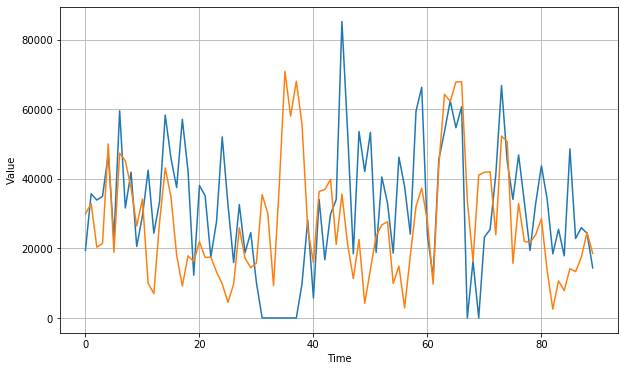

In [1721]:
rmse = sqrt(mean_squared_error(df1.iloc[split_time:,-1], yhat))
mae = mean_absolute_error(df1.iloc[split_time:,-1], yhat)
print('Test RMSE is ;', rmse)
print('Test MAE of is :' , mae)
plt.figure(figsize=(10, 6))
plot_series(range(len(yhat)), df1.iloc[split_time:,-1])
plot_series(range(len(yhat)), yhat)

## Final Predictions on Unseen data

### Final Predictions for Cashin

In [1743]:
df1 = df.copy()

In [1744]:
df1['CashIn_t3'] = df1.CashIn.shift(3)
df1['CashIn_t2'] = df1.CashIn.shift(2)
df1['CashIn_t1'] = df1.CashIn.shift(1)


In [1745]:
df1 = df1[ [col for col in df1.columns if col != 'CashIn'] + ['CashIn'] ]

In [1746]:
df1[['CashIn', 'CashIn_t1', 'CashIn_t2','CashIn_t3']].head(8)

,CashIn,CashIn_t1,CashIn_t2,CashIn_t3
0,0.0,NaN,NaN,NaN
1,0.0,0.0,NaN,NaN
2,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0
4,20840.0,0.0,0.0,0.0
5,28460.0,20840.0,0.0,0.0
6,19250.0,28460.0,20840.0,0.0
7,49770.0,19250.0,28460.0,20840.0


In [1747]:
df1.dropna(inplace=True)
df1 = df1.reset_index(drop=True)

In [1748]:
df1.drop(['Date', 'CashOut', ], axis=1, inplace = True)

In [1749]:
split_time = 1093
X_train = df1[:split_time]
X_test = df1[split_time:]


In [1751]:
parameters = {
    "learning_rate": [ 0.1, 0.2, 0.3],
    "max_depth":[3, 5],
    "n_estimators":[100, 150, 200]
    }

In [1754]:
gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid = parameters,refit=False,cv=2, n_jobs=-1)
gb.fit(X_train.iloc[:,:-1], X_train.iloc[:,-1])


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [3, 5],
                         'n_estimators': [100, 150, 200]},
             refit=False)

In [1755]:
gb.cv_results_
gb.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Default learning rate, max_depth and n_estimators values provides best results among tried combinations. So I will continue with default values.

In [1756]:
model = GradientBoostingRegressor()
model.fit(X_train.iloc[:,:-1], X_train.iloc[:,-1])


GradientBoostingRegressor()

In [1760]:
def walk_forward_prediction(data, model, index):
    # yhat = []
    for idx, i in enumerate(index):
        if len(yhat)==0:
            data.CashIn_t1[i] = data.CashIn[i-1] 
            data.CashIn_t2[i] = data.CashIn[i-2] 
            data.CashIn_t3[i] = data.CashIn[i-3] 
        elif len(yhat)==1:
            data.CashIn_t1[i] = yhat[idx-1]
            data.CashIn_t2[i] = data.CashIn[i-2] 
            data.CashIn_t3[i] = data.CashIn[i-3]   
        elif len(yhat)==2:
            data.CashIn_t1[i] = yhat[idx-1]
            data.CashIn_t2[i] = yhat[idx-2]
            data.CashIn_t3[i] = data.CashIn[i-3]   
        else:
            data.CashIn_t1[i] = yhat[idx-1]
            data.CashIn_t2[i] = yhat[idx-2]
            data.CashIn_t3[i] = yhat[idx-3]

        yhat.append(model.predict(np.asarray(data.iloc[i,:-1]).reshape(1, -1)))
        print('Input: ', data.iloc[i,-1],'Predicted: ' ,yhat[idx])

In [1761]:
yhat = []
walk_forward_prediction(df1, model, df1[split_time:].index)

Input:  27510.0 Predicted:  [33132.50190193]
Input:  58800.0 Predicted:  [34226.28975633]
Input:  57580.0 Predicted:  [36949.87229398]
Input:  39090.0 Predicted:  [33882.24106791]
Input:  57920.0 Predicted:  [23883.49908651]
Input:  15960.0 Predicted:  [25158.98378338]
Input:  52850.0 Predicted:  [49869.80237251]
Input:  72720.0 Predicted:  [38386.5778758]
Input:  49140.0 Predicted:  [36095.64384534]
Input:  69900.0 Predicted:  [32510.06657264]
Input:  29430.0 Predicted:  [26964.48602006]
Input:  22140.0 Predicted:  [19761.58504606]
Input:  20340.0 Predicted:  [18200.983313]
Input:  57200.0 Predicted:  [41997.15627292]
Input:  68110.0 Predicted:  [38395.39597776]
Input:  41900.0 Predicted:  [38308.79193538]
Input:  79110.0 Predicted:  [36262.4283921]
Input:  44890.0 Predicted:  [24871.84002177]
Input:  17530.0 Predicted:  [16688.44179871]
Input:  18100.0 Predicted:  [16862.47337966]
Input:  68570.0 Predicted:  [42002.28847649]
Input:  52660.0 Predicted:  [36513.69194805]
Input:  48610.

Test RMSE of  GradientBoostingRegressor is : 21726.272986438544
Test MAE of  GradientBoostingRegressor is : 17577.92052794757


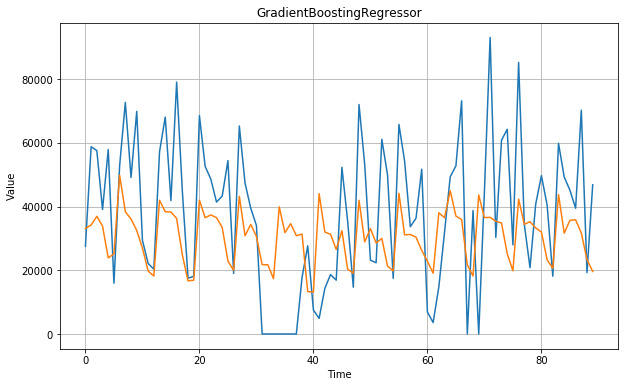

In [1762]:
rmse = sqrt(mean_squared_error(X_test.iloc[:,-1], yhat))
mae = mean_absolute_error(X_test.iloc[:,-1], yhat)
print('Test RMSE of ', str(model).split('(')[0], 'is :' , rmse)
print('Test MAE of ', str(model).split('(')[0], 'is :' , mae)
plt.figure(figsize=(10, 6))
plt.title(str(model).split('(')[0])
plot_series(range(len(yhat)), X_test.iloc[:,-1])
plot_series(range(len(yhat)), yhat)

In [1763]:
df1 = df.copy()

In [1764]:
df1['CashIn_t3'] = df1.CashIn.shift(3)
df1['CashIn_t2'] = df1.CashIn.shift(2)
df1['CashIn_t1'] = df1.CashIn.shift(1)


In [1765]:
df1 = df1[ [col for col in df1.columns if col != 'CashIn'] + ['CashIn'] ]

In [1766]:
df1[['CashIn', 'CashIn_t1', 'CashIn_t2','CashIn_t3']].head(8)

,CashIn,CashIn_t1,CashIn_t2,CashIn_t3
0,0.0,NaN,NaN,NaN
1,0.0,0.0,NaN,NaN
2,0.0,0.0,0.0,NaN
3,0.0,0.0,0.0,0.0
4,20840.0,0.0,0.0,0.0
5,28460.0,20840.0,0.0,0.0
6,19250.0,28460.0,20840.0,0.0
7,49770.0,19250.0,28460.0,20840.0


In [1767]:
df1.drop(['Date', 'CashOut', ], axis=1, inplace = True)

In [1768]:
df1.tail()

,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,first_bday_of_month,last_bday_of_month,...,day__31,week__1,week__2,week__3,week__4,week__5,CashIn_t3,CashIn_t2,CashIn_t1,CashIn
1211,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
1212,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
1213,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
1214,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,NaN,NaN,NaN,NaN
1215,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,NaN,NaN,NaN,NaN


In [1769]:
unseen_startdate = df[df.Date == '2019-04-01'].index[0]

In [1770]:
yhat = []
walk_forward_prediction(df1, model, df1[unseen_startdate:].index)

Input:  nan Predicted:  [51839.48015341]
Input:  nan Predicted:  [37063.7009221]
Input:  nan Predicted:  [37440.12443482]
Input:  nan Predicted:  [35849.68686995]
Input:  nan Predicted:  [33920.31602467]
Input:  nan Predicted:  [31890.97023106]
Input:  nan Predicted:  [19883.43236984]
Input:  nan Predicted:  [46793.21517614]
Input:  nan Predicted:  [35438.54764152]
Input:  nan Predicted:  [34538.98319793]
Input:  nan Predicted:  [34403.5021091]
Input:  nan Predicted:  [32370.7623122]
Input:  nan Predicted:  [23308.14823351]
Input:  nan Predicted:  [19281.05675977]
Input:  nan Predicted:  [42751.03764374]
Input:  nan Predicted:  [37986.61240953]
Input:  nan Predicted:  [35644.91152932]
Input:  nan Predicted:  [34437.2834814]
Input:  nan Predicted:  [30368.66146563]
Input:  nan Predicted:  [23308.14823351]
Input:  nan Predicted:  [19181.13209497]
Input:  nan Predicted:  [42984.3883506]
Input:  nan Predicted:  [36494.62086672]
Input:  nan Predicted:  [38475.4166712]
Input:  nan Predicted:

In [1771]:
cashin_predictions = [yh for yhs in yhat for yh in yhs]

In [1773]:
len(cashin_predictions)

30

### Final Predictions for Cashout

In [1695]:
df1 = df.copy()

In [1696]:
df1['CashOut_t3'] = df1.CashOut.shift(3)
df1['CashOut_t2'] = df1.CashOut.shift(2)
df1['CashOut_t1'] = df1.CashOut.shift(1)


In [1697]:
df1 = df1[ [col for col in df1.columns if col != 'CashOut'] + ['CashOut'] ]

In [1699]:
df1.dropna(inplace=True)
df1 = df1.reset_index(drop=True)

In [1701]:
df1.drop(['Date', 'CashIn', ], axis=1, inplace = True)

In [1702]:
split_time = 1093
X_train = df1[:split_time]
X_test = df1[split_time:]


In [1722]:
parameters = {
    "learning_rate": [ 0.1, 0.2, 0.3],
    "max_depth":[3, 5],
    "n_estimators":[100, 150, 200]
    }

In [1723]:
gb = GridSearchCV(estimator=GradientBoostingRegressor(), param_grid = parameters,refit=False,cv=2, n_jobs=-1)
gb.fit(X_train.iloc[:,:-1], X_train.iloc[:,-1])


GridSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.2, 0.3], 'max_depth': [3, 5],
                         'n_estimators': [100, 150, 200]},
             refit=False)

In [1724]:
gb.cv_results_
gb.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

Default learning rate, max_depth and n_estimators values provides best results among tried combinations. So I will continue with default values.

In [1725]:
model = GradientBoostingRegressor()
model.fit(X_train.iloc[:,:-1], X_train.iloc[:,-1])


GradientBoostingRegressor()

In [1758]:
def walk_forward_prediction(data, model, index):
    # yhat = []
    for idx, i in enumerate(index):
        if len(yhat)==0:
            data.CashOut_t1[i] = data.CashOut[i-1] 
            data.CashOut_t2[i] = data.CashOut[i-2] 
            data.CashOut_t3[i] = data.CashOut[i-3] 
        elif len(yhat)==1:
            data.CashOut_t1[i] = yhat[idx-1]
            data.CashOut_t2[i] = data.CashOut[i-2] 
            data.CashOut_t3[i] = data.CashOut[i-3]   
        elif len(yhat)==2:
            data.CashOut_t1[i] = yhat[idx-1]
            data.CashOut_t2[i] = yhat[idx-2]
            data.CashOut_t3[i] = data.CashOut[i-3]   
        else:
            data.CashOut_t1[i] = yhat[idx-1]
            data.CashOut_t2[i] = yhat[idx-2]
            data.CashOut_t3[i] = yhat[idx-3]

        yhat.append(model.predict(np.asarray(data.iloc[i,:-1]).reshape(1, -1)))
        print('Input: ', data.iloc[i,-1],'Predicted: ' ,yhat[idx])

In [1726]:
yhat = []
walk_forward_prediction(df1, model, df1[split_time:].index)

Input:  19440.0 Predicted:  [31334.16167188]
Input:  35700.0 Predicted:  [32619.46317252]
Input:  33900.0 Predicted:  [33560.57582218]
Input:  34970.0 Predicted:  [37853.00212895]
Input:  47050.0 Predicted:  [51899.1870864]
Input:  22820.0 Predicted:  [22042.13679751]
Input:  59560.0 Predicted:  [59195.20503392]
Input:  31619.999999999996 Predicted:  [39818.17699896]
Input:  41930.0 Predicted:  [29194.84511322]
Input:  20560.0 Predicted:  [29901.63748902]
Input:  29350.0 Predicted:  [35691.30848278]
Input:  42490.0 Predicted:  [27393.11092887]
Input:  24360.0 Predicted:  [14268.7704193]
Input:  33380.0 Predicted:  [29610.91407281]
Input:  58340.0 Predicted:  [45072.84276599]
Input:  45980.0 Predicted:  [32167.26944884]
Input:  37490.0 Predicted:  [28933.09494597]
Input:  57100.0 Predicted:  [31633.6009711]
Input:  42240.0 Predicted:  [29479.10298992]
Input:  12300.0 Predicted:  [13963.54607358]
Input:  38080.0 Predicted:  [29204.87037835]
Input:  35140.0 Predicted:  [27304.54295007]
In

Test RMSE of  GradientBoostingRegressor is : 17685.58546272772
Test MAE of  GradientBoostingRegressor is : 12910.461261712764


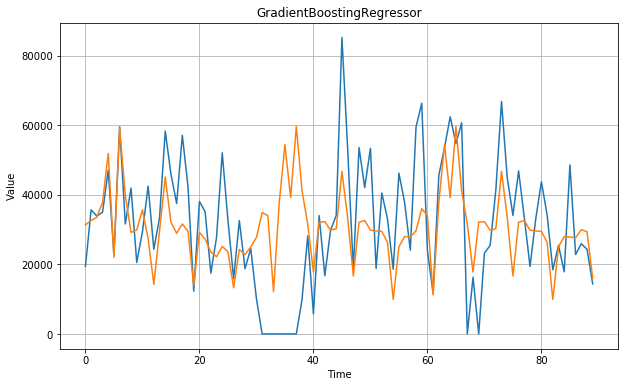

In [1727]:
rmse = sqrt(mean_squared_error(X_test.iloc[:,-1], yhat))
mae = mean_absolute_error(X_test.iloc[:,-1], yhat)
print('Test RMSE of ', str(model).split('(')[0], 'is :' , rmse)
print('Test MAE of ', str(model).split('(')[0], 'is :' , mae)
plt.figure(figsize=(10, 6))
plt.title(str(model).split('(')[0])
plot_series(range(len(yhat)), X_test.iloc[:,-1])
plot_series(range(len(yhat)), yhat)

In [1728]:
df1 = df.copy()

In [1729]:
df1['CashOut_t3'] = df1.CashOut.shift(3)
df1['CashOut_t2'] = df1.CashOut.shift(2)
df1['CashOut_t1'] = df1.CashOut.shift(1)


In [1730]:
df1 = df1[ [col for col in df1.columns if col != 'CashOut'] + ['CashOut'] ]

In [1731]:
df1[['CashOut', 'CashOut_t1', 'CashOut_t2','CashOut_t3']].head(8)

,CashOut,CashOut_t1,CashOut_t2,CashOut_t3
0,6500.0,NaN,NaN,NaN
1,23110.0,6500.0,NaN,NaN
2,7070.0,23110.0,6500.0,NaN
3,18520.0,7070.0,23110.0,6500.0
4,22200.0,18520.0,7070.0,23110.0
5,18810.0,22200.0,18520.0,7070.0
6,23210.0,18810.0,22200.0,18520.0
7,4350.0,23210.0,18810.0,22200.0


In [1732]:
df1.drop(['Date', 'CashIn', ], axis=1, inplace = True)

In [1733]:
df1.tail()

,is_bday,is__Friday,is__Monday,is__Saturday,is__Sunday,is__Thursday,is__Tuesday,is__Wednesday,first_bday_of_month,last_bday_of_month,...,day__31,week__1,week__2,week__3,week__4,week__5,CashOut_t3,CashOut_t2,CashOut_t1,CashOut
1211,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
1212,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
1213,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,NaN,NaN,NaN,NaN
1214,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,NaN,NaN,NaN,NaN
1215,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,NaN,NaN,NaN,NaN


In [1734]:
unseen_startdate = df[df.Date == '2019-04-01'].index[0]

In [1735]:
yhat = []
walk_forward_prediction(df1, model, df1[unseen_startdate:].index)

Input:  nan Predicted:  [31962.50426801]
Input:  nan Predicted:  [34153.88705581]
Input:  nan Predicted:  [30768.01681205]
Input:  nan Predicted:  [36623.67900057]
Input:  nan Predicted:  [54977.95250479]
Input:  nan Predicted:  [45971.10974762]
Input:  nan Predicted:  [23355.48348941]
Input:  nan Predicted:  [37702.2906149]
Input:  nan Predicted:  [33755.37043628]
Input:  nan Predicted:  [30092.80221479]
Input:  nan Predicted:  [30264.66744572]
Input:  nan Predicted:  [32599.14721109]
Input:  nan Predicted:  [31001.20631725]
Input:  nan Predicted:  [16337.38145961]
Input:  nan Predicted:  [49264.06496093]
Input:  nan Predicted:  [35250.90080186]
Input:  nan Predicted:  [29600.12982609]
Input:  nan Predicted:  [30708.25937274]
Input:  nan Predicted:  [32599.14721109]
Input:  nan Predicted:  [31001.20631725]
Input:  nan Predicted:  [15686.24092356]
Input:  nan Predicted:  [27772.99625427]
Input:  nan Predicted:  [28070.36907416]
Input:  nan Predicted:  [25775.85204231]
Input:  nan Predi

In [1738]:
cashout_predictions = [yh for yhs in yhat for yh in yhs]

In [1740]:
len(cashout_predictions)

30

In [1774]:
predictions_final = pd.DataFrame(columns=['Date','CashIn','CashOut'])

In [1779]:
predictions_final['Date'] = df[unseen_startdate:].Date

In [1781]:
predictions_final['CashIn'] =  cashin_predictions

In [1782]:
predictions_final['CashOut'] =  cashout_predictions

In [1783]:
predictions_final

,Date,CashIn,CashOut
1186,2019-04-01,51839.480153,31962.504268
1187,2019-04-02,37063.700922,34153.887056
1188,2019-04-03,37440.124435,30768.016812
1189,2019-04-04,35849.686870,36623.679001
1190,2019-04-05,33920.316025,54977.952505
1191,2019-04-06,31890.970231,45971.109748
1192,2019-04-07,19883.432370,23355.483489
1193,2019-04-08,46793.215176,37702.290615
1194,2019-04-09,35438.547642,33755.370436
1195,2019-04-10,34538.983198,30092.802215


In [1784]:
predictions_final.to_csv('predictions.csv', index=False)